# Bayesian model mixing: a sandbox of possibilities

## Written by: Alexandra Semposki

### Date: 16-31 August 2021

Here in this notebook I have constructed an interactive example of the Bayesian model mixing toy model project I have been working on for the summer of 2021. Let's first begin with some background mathematics to describe the problem at hand.

Suppose I have a function, such as the one below, which can be described as the zero-dimensional $\phi^{4}$ theory partition function:

$$
F(g) = \int_{-\infty}^{\infty} dx ~ e^{\frac{-x^{2}}{2} - g^{2}x^{4}} = \frac{e^{\frac{1}{32 g^{2}}}}{2 \sqrt{2} g} K_{\frac{1}{4}} \left( \frac{1}{32 g^{2}} \right)
$$

where $K$ is the modified Bessel function of the second kind. We want to expand this function in the limits of low $g$ and high $g$, specifically $g = 0$ and $g = \infty$. The expansions are below. For $g = 0$, 

$$
F_{s}^{(N_{s})} (g) = \sum_{k = 0}^{N_{s}} s_{k} g^{k},
$$

where 

$$
s_{2k + 1} = 0,
$$

and

$$
s_{2k} = \frac{\sqrt{2}~ \Gamma{(2k + 1/2)}}{k!}(-4)^{k}.
$$

$N_{s}$ is the highest order we will specify for our series. 

For $g = \infty$, 

$$
F_{l}^{(N_{l})} (g) = \frac{1}{\sqrt{g}} \sum_{k = 0}^{N_{l}} l_{k} g^{-k}, 
$$

where 

$$
l_{k} = \frac{\Gamma{\left(\frac{k}{2} + \frac{1}{4}\right)}}{2k!} \left(-\frac{1}{2}\right)^{k}.
$$

The two expansions above represent some models we have been able to obtain from the "data" that we collected in the lab. Now we want to see what these expansions look like in a plot. This will depend on which value of $k$ we choose for which expansion. Let's pick $k$ = 5 for the small-$g$ expansion and $k$ = 23 for the large-$g$ expansion.

In [1]:
#import necessary packages
import numpy as np
import math
import statistics
import emcee
import corner
from cycler import cycler
from scipy import stats, special, integrate

import matplotlib.pyplot as plt
%matplotlib inline

#import classes we'll need
from mixing import Switching, Mixing, Models
from discrepancy import Discrepancy
from priors import Priors
from uncertainties import Uncertainties

#matplotlib settings for Latex plots
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

First we will make a class object:

In [2]:
highk = np.array([5])

new = Mixing(highk)

Instantiating the linear mixture model method.


Now we can look at the functions of the class to see what we will need to plot the expansions we want. 

In [3]:
dir(Mixing)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_autocorrelation',
 '_select_function',
 'add_data',
 'burnin_trace',
 'cdf',
 'credible_intervals',
 'high_g',
 'hypertan',
 'likelihood_high',
 'likelihood_low',
 'logistic',
 'low_g',
 'lpdf',
 'luniform',
 'mixed_model',
 'plot_data',
 'plot_models',
 'plot_ppd',
 'ppd',
 'residuals',
 'sampler_mix',
 'stats_chain',
 'stats_trace',
 'switchcos',
 'true_model']

From here, it looks like we want the 'plot_models' function. Let's start with that. We run the 'help()' command to see what inputs that function needs.

In [4]:
help(Mixing.plot_models)

Help on function plot_models in module mixing:

plot_models(self, g, loworder)
    A plotting function to produce a figure of the model expansions calculated in Models.low_g and Models.high_g, 
    and including the true model calculated using Mixing.true_model.
    
    :Example:
        Mixing.plot_models(g=np.linspace(0.0, 0.5, 100), lowk=np.array([5, 23]), highk=np.array([5, 23]))
        
    Parameters:
    -----------
    g : linspace
        The linspace in on which the models will be plotted here. 
    
    loworder : numpy.ndarray, int, float   
        As in Models.low_g, the highest powers to calculate the series to for the asymptotic small-g expansion.
             
    Returns
    -------
    None.



We now can set up the necessary parameters, using the example given in the plot_models function docstring.

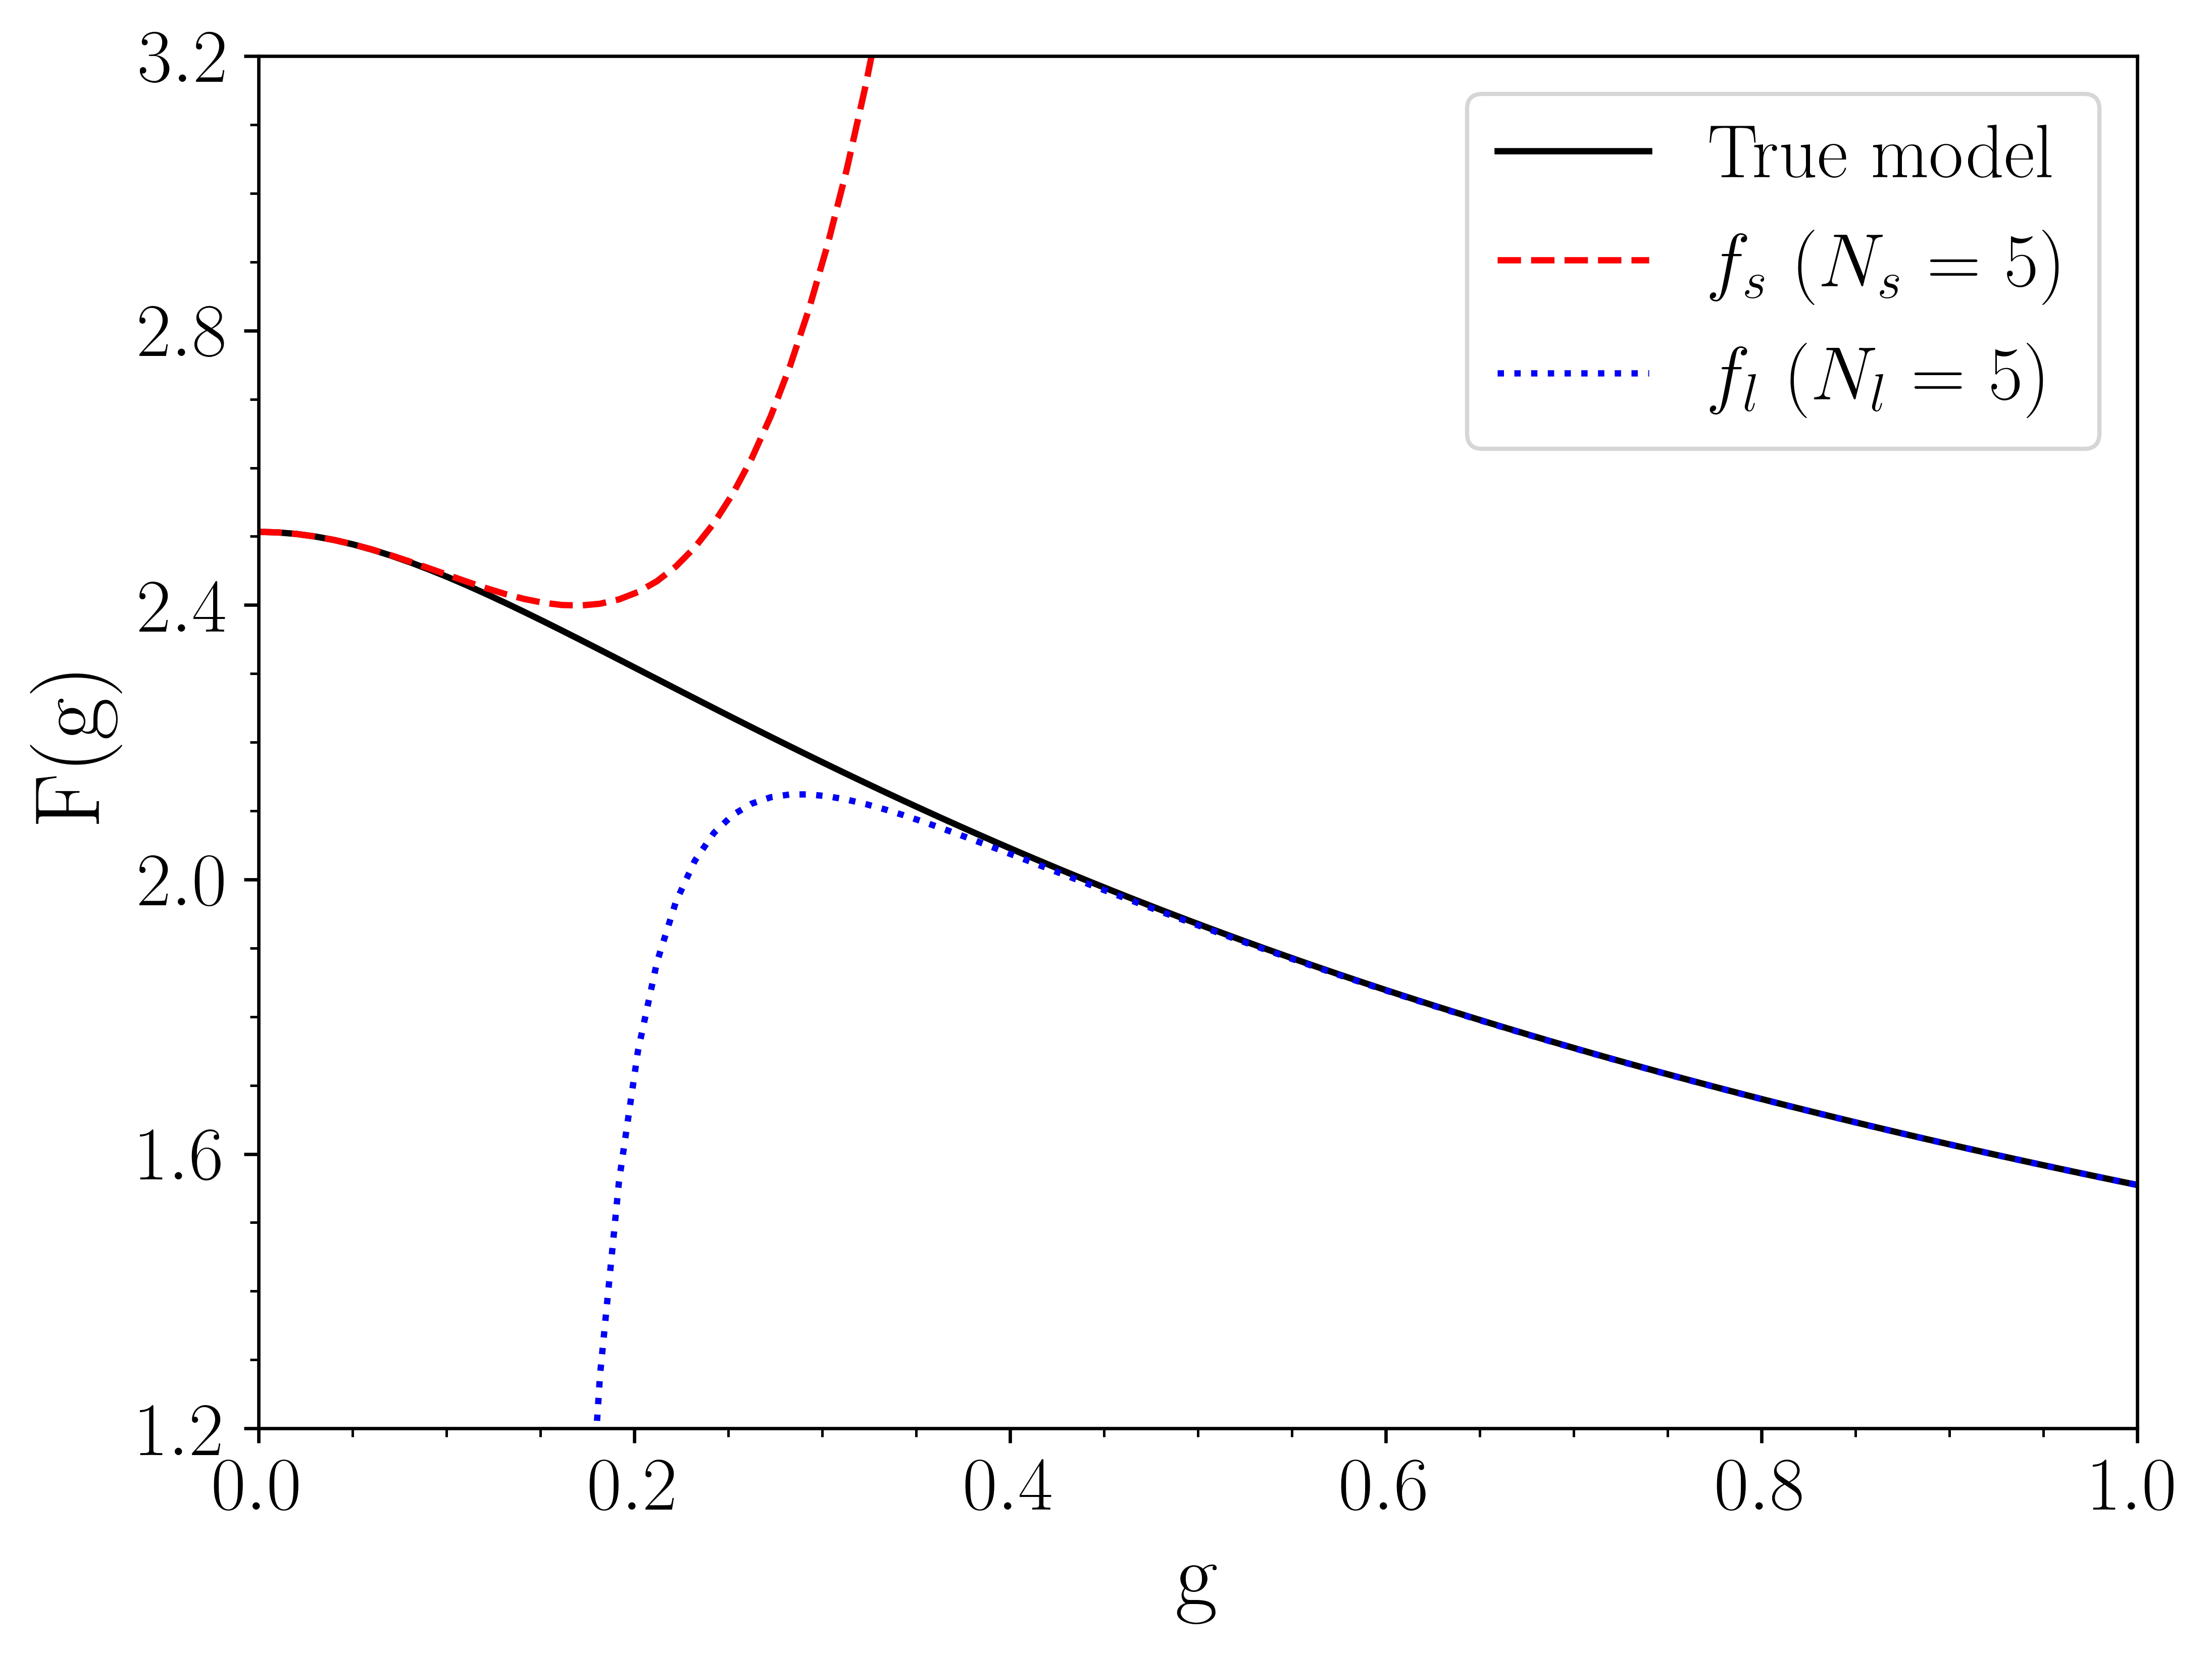

Would you like to save this figure? (yes/no)no


In [5]:
g = np.linspace(1e-6, 1.0, 100)
lowk = np.array([5])
highk = np.array([5])

new.plot_models(g, lowk)

Because this is a toy model, we can calculate the true model (the partition function in full form as shown mathematically above) and compare to the expansions. 

## Mixing method 1: the linear mixture model

There are two different methods that we can implement when it comes to mixing these expansions. We'll explore the linear mixture formulation first.

Now we would like to generate some data from this true model and see what we can do with it. 


y-limits (enter "auto" if unknown): auto


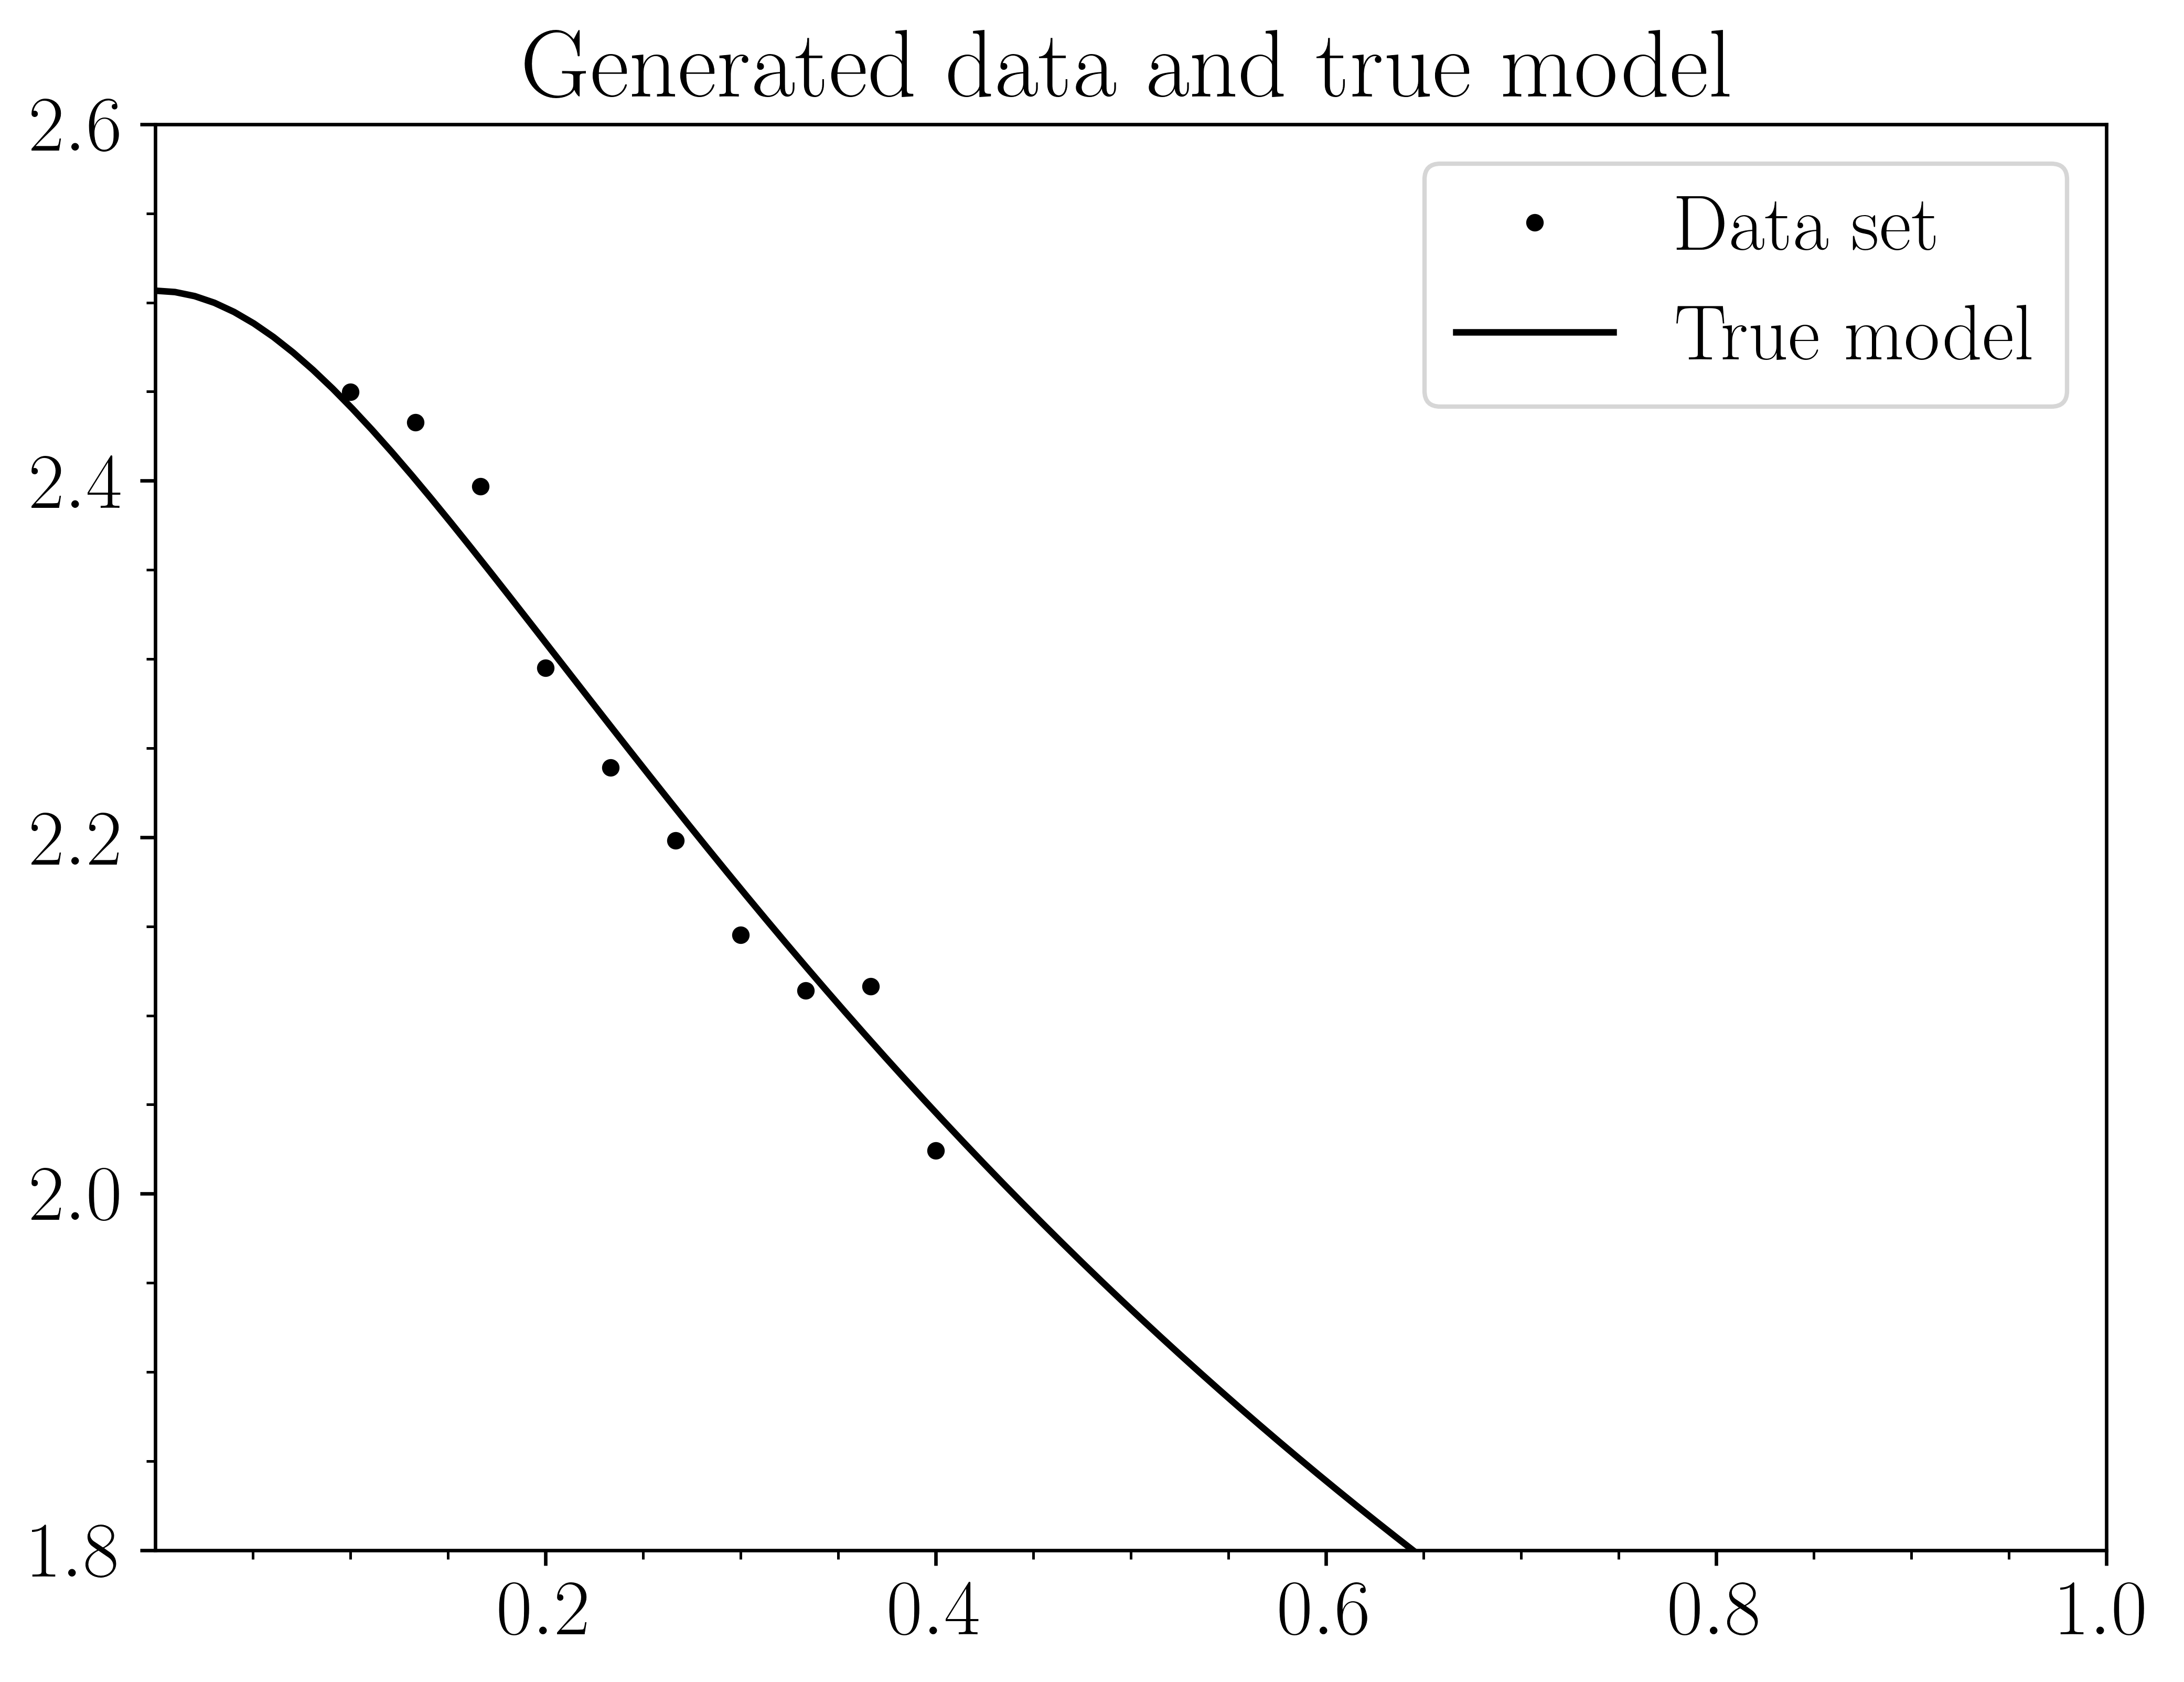

Would you like to save this figure? (yes/no)no


(array([2.44983076, 2.4328951 , 2.39674125, 2.29493439, 2.23914034,
        2.19832407, 2.14508968, 2.11401214, 2.1162461 , 2.02427071]),
 array([0.02449831, 0.02432895, 0.02396741, 0.02294934, 0.0223914 ,
        0.02198324, 0.0214509 , 0.02114012, 0.02116246, 0.02024271]))

In [6]:
# g_data = np.linspace(0.1, 0.8, 25)
g_data = np.linspace(0.1, 0.4, 10)

#seed the data and sigma for now (this one for 2 v 2)
# data = np.array([2.43628328, 2.45359171, 2.31921813, 2.36417193, 2.28698692,
#         2.25342963, 2.21253294, 2.1549666 , 2.13741573, 2.08466555,
#         2.02902091, 2.02415175, 1.98509156, 1.98785748, 1.88562842,
#         1.88795389, 1.85446963, 1.85925744, 1.81013163, 1.78104961,
#         1.77021702, 1.7538542 , 1.71260423, 1.68076455, 1.69051721])

# sigma = np.array([0.02436283, 0.02453592, 0.02319218, 0.02364172, 0.02286987,
#         0.0225343 , 0.02212533, 0.02154967, 0.02137416, 0.02084666,
#         0.02029021, 0.02024152, 0.01985092, 0.01987857, 0.01885628,
#         0.01887954, 0.0185447 , 0.01859257, 0.01810132, 0.0178105 ,
#         0.01770217, 0.01753854, 0.01712604, 0.01680765, 0.01690517])

data = np.array([2.44983076, 2.4328951 , 2.39674125, 2.29493439, 2.23914034,
        2.19832407, 2.14508968, 2.11401214, 2.1162461 , 2.02427071])

sigma = np.array([0.02449831, 0.02432895, 0.02396741, 0.02294934, 0.0223914 ,
        0.02198324, 0.0214509 , 0.02114012, 0.02116246, 0.02024271])

new.add_data(g, g_data, data, sigma)

In [7]:
print(data, sigma)

[2.44983076 2.4328951  2.39674125 2.29493439 2.23914034 2.19832407
 2.14508968 2.11401214 2.1162461  2.02427071] [0.02449831 0.02432895 0.02396741 0.02294934 0.0223914  0.02198324
 0.0214509  0.02114012 0.02116246 0.02024271]


Now that we have some data to work with, we would like to take our two models and see if we can mix them in a way that will match the true model as much as possible, without being too informed of what it should look like. First, we need to assess what kind of model mixing we will be doing---in our case, we'll try a simple linear mixture model. This can be described mathematically as follows. The likelihood in such a mixing model is given generally as:

$$
p(\mathbf{y}|\theta_{1}, \theta_{2}) = \prod_{i=1}^{n} \left\{ f(x_{i}) \left[ \left(\frac{1}{\sqrt{2 \pi} \sigma} \right) \exp\left(\frac{-(y_{i} - f_{1}(\theta_{1}, x_{i}))}{2 \sigma^{2}}\right) \right] + (1 - f(x_{i})) \left[ \left(\frac{1}{\sqrt{2 \pi} \sigma} \right) \exp\left(\frac{-(y_{i} - f_{2}(\theta_{2}, x_{i}))}{2 \sigma^{2}}\right) \right] \right\}
$$

$$
p(\mathbf{y}|\mathbf{\theta}) = \prod_{i=1}^{n} \left\{ \alpha(g_{i}, \mathbf{\theta}) ~\mathcal{N}(f_{s}(g_{i}), \sigma_{d_{i}}^{2}) + (1 - \alpha(g_{i}))~ \mathcal{N}(f_{l}(g_{i}), \sigma_{d_{i}}^{2})\right\}
$$

According to Bayes' theorem, the posterior of a distribution is given by the likelihood multiplied by the prior, as below:

$$
p(\theta|d) = p(d|\theta)p(\theta),
$$

so we'll need a prior distribution for each parameter, $\theta$, that we need to determine. The number of parameters depends on the switching function, $f(x)$, we choose.

We will also need to take the logarithm of Bayes' theorem for the parameter estimation to work well here, so we'll obtain:

$$
\log(p(\theta|d)) = \log(p(d|\theta)) + \log(p(\theta)).
$$

Let's look at the switching functions available to us. 

In [8]:
dir(Switching)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cdf',
 'hypertan',
 'logistic',
 'plot_ppd',
 'ppd',
 'switchcos']

This shows only 3: 'cdf', 'logistic', and 'switchcos'. Let's use the cosine one.

In [9]:
help(Switching.switchcos)

Help on function switchcos in module mixing:

switchcos(self, params, g)
    A piecewise function using two constants at either end, and two cosine functions in the centre,
    to be used as a switching function. One free parameter, g3, is found by sampling. 
    
    :Example:
        Switching.switchcos(params=np.array(), g=0.5)
        
    Parameters:
    -----------
    params : numpy.ndarray
        The array of parameters to be determined by the sampler (here labelled g1, g2, and g3, where
        g1 is the separation point between the first constant function and the first cosine function, 
        g2 is the separation point between the second cosine function and the second constant function, 
        and g3 is the point between the two cosine functions). 
    
    g : float
        The value of g that this cosine function is calculated at.
    
    Returns:
    --------
        The value of the function at a specific point in g.



Let's look at what this function is supposed to look like across $g$ space, given some parameter guesses. 

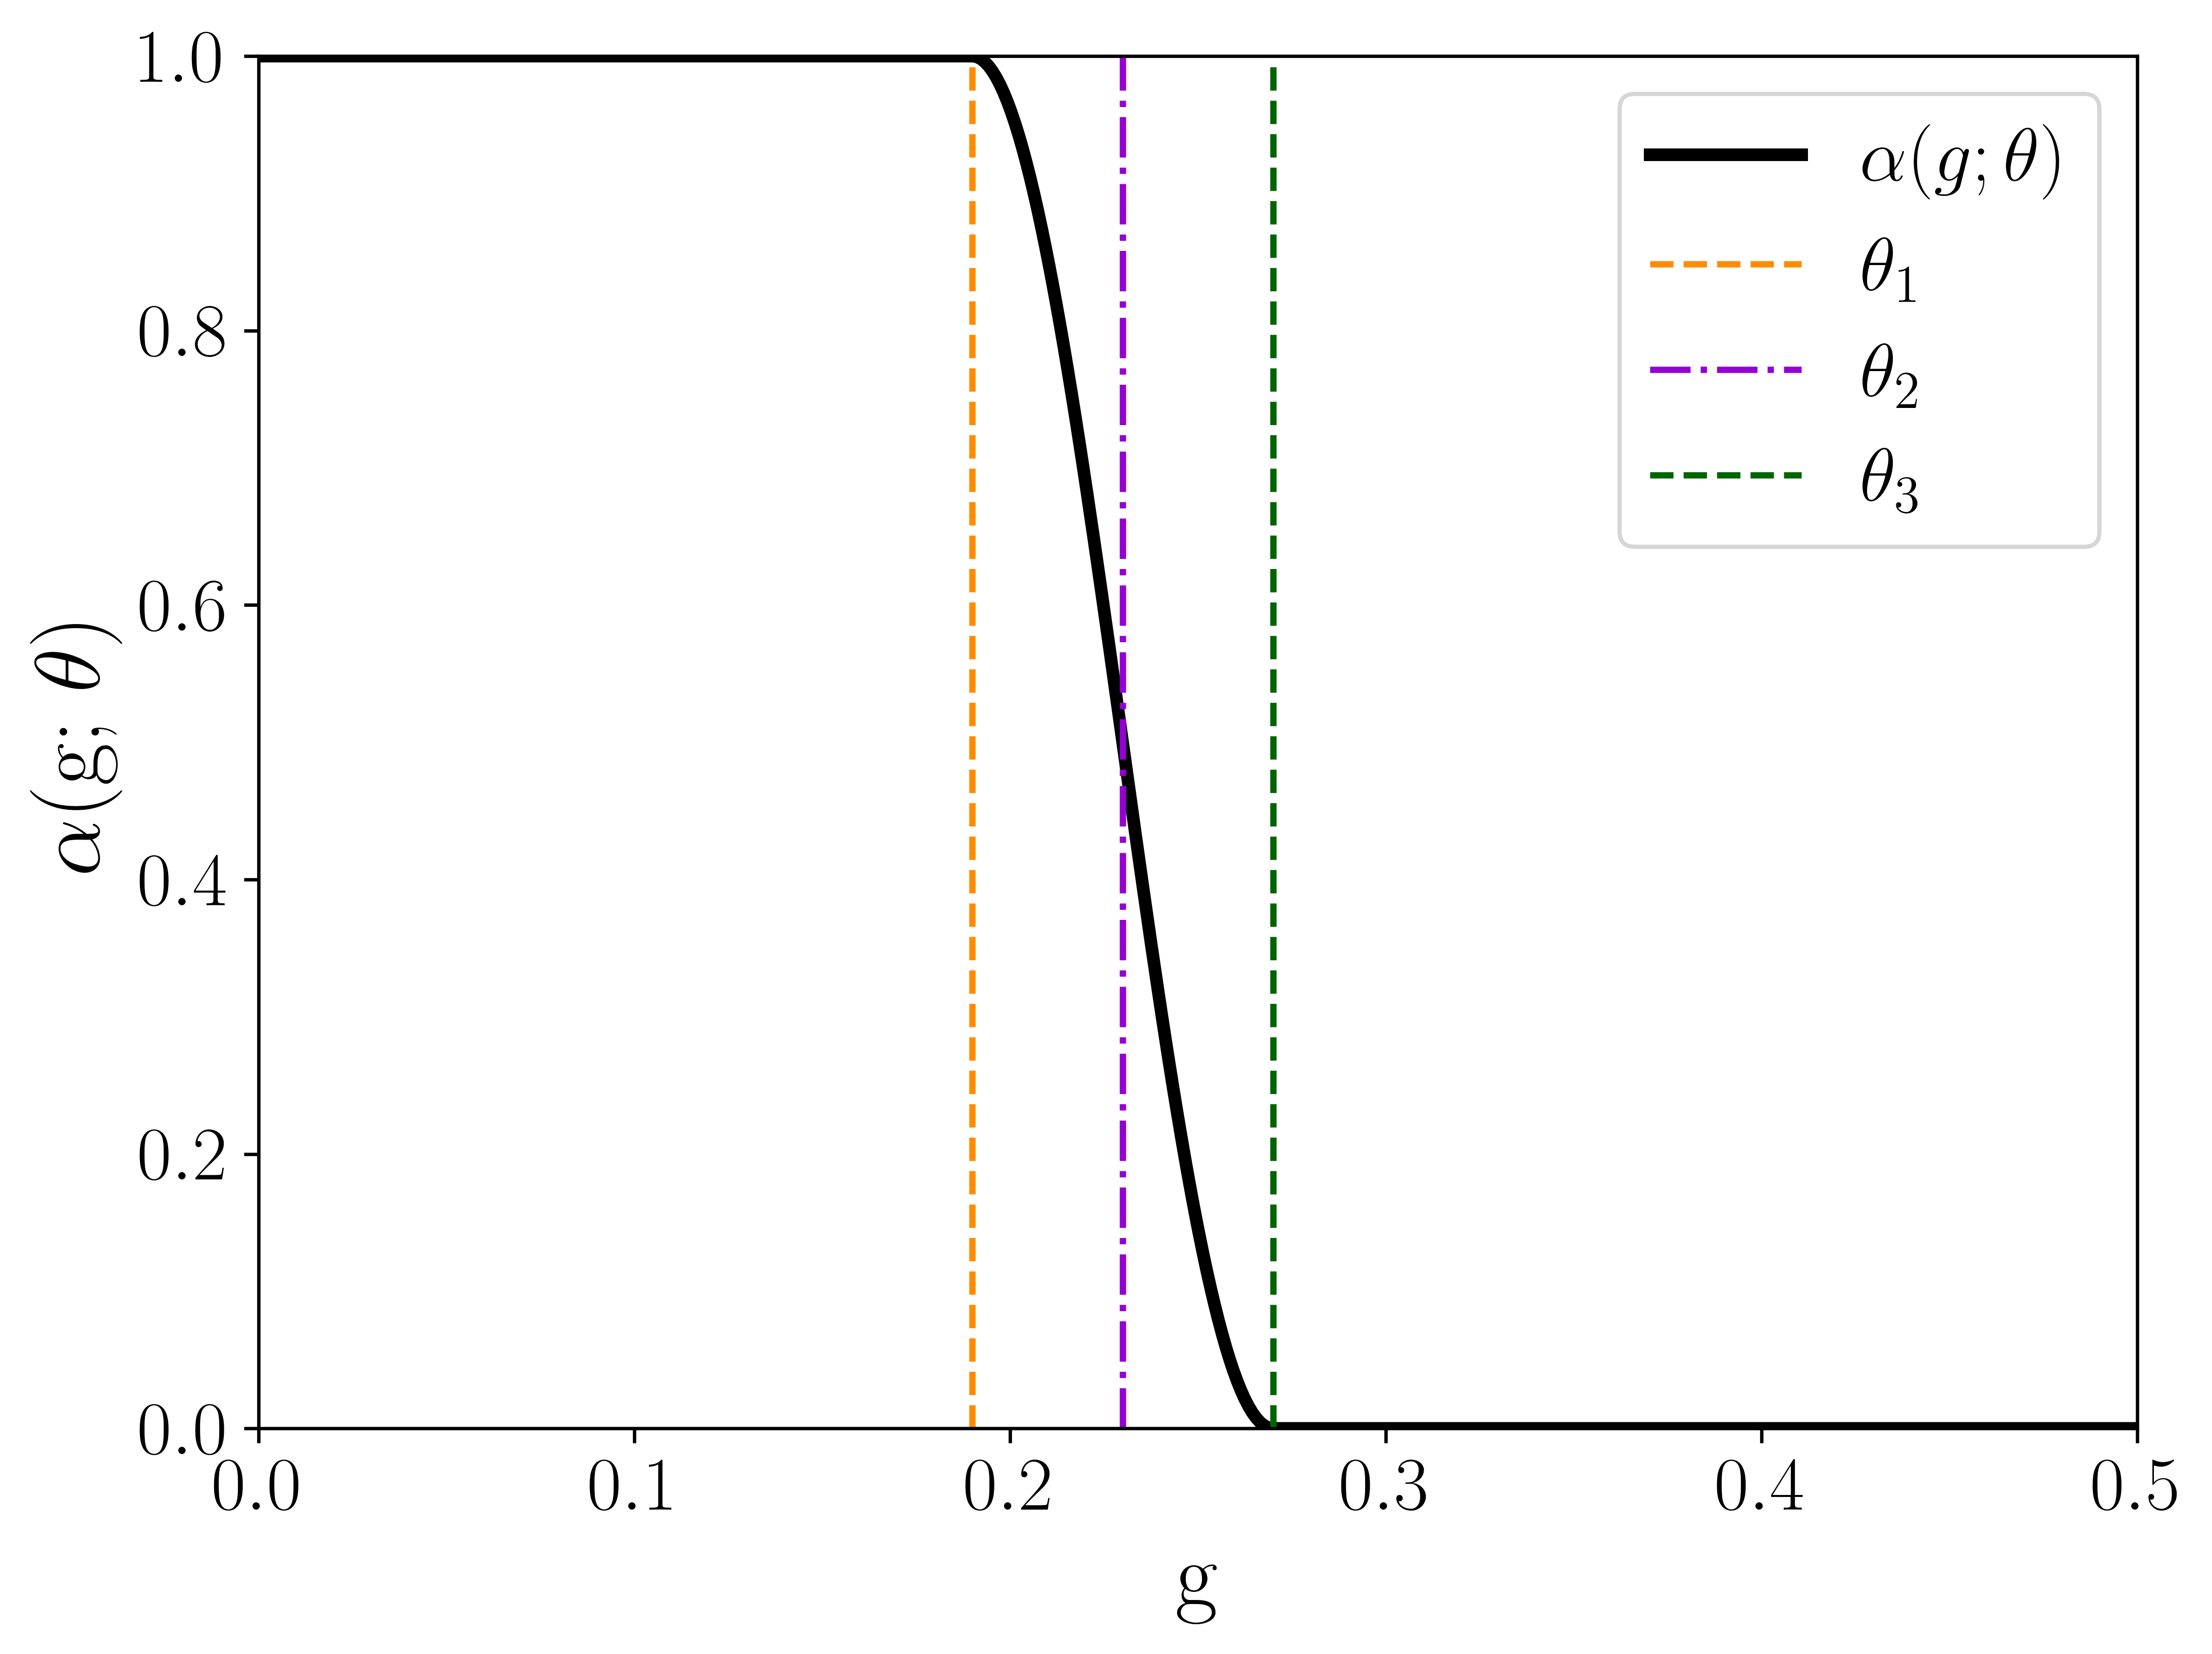

In [10]:
g_plot = np.linspace(1e-6, 0.5, 500)

fig = plt.figure(figsize=(8,6), dpi=600)
ax1 = plt.axes()
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax1.set_xlim(0.0, 0.5)
ax1.set_ylim(0.0,1.0)
ax1.set_xlabel('g', fontsize=22)
ax1.set_ylabel(r'$\alpha$(g; $\theta$)', fontsize=22)
#ax1.set_title('Cosine mixing function', fontsize=22)

switch = np.zeros([len(g_plot)])

#solve the cosine function first
for i in range(len(g_plot)):
    switch[i] = new.switchcos(np.array([0.19, 0.27, 0.23]), g_plot[i])

ax1.plot(g_plot, switch, 'k', linewidth=3, label=r'$\alpha(g; \theta)$')    
ax1.axvline(x=0.19, color='darkorange', linestyle='dashed', label=r'$\theta_{1}$')
ax1.axvline(x=0.23, color='darkviolet', linestyle='dashdot', label=r'$\theta_{2}$')
ax1.axvline(x=0.27, color='darkgreen', linestyle='dashed', label=r'$\theta_{3}$')

ax1.legend(fontsize=18)

fig.savefig('mixing_plot.pdf', bbox_inches='tight')

Now we are ready to determine some priors for g1, g2, and g3. These must be set by the user, and are already done in the file priors.py, which can be accessed [here](./priors.py).

In this file, we have preset the priors to be normally distributed for each parameter, with the means equal to 0.11, 0.16, and 0.2 (g1, g3, and g2, respectively), with standard deviations of 0.01 each. This is a VERY precise standard deviation, which we will get to later on. 

Now, let's call the mixing model. 

In [11]:
chainr, trace = new.mixed_model(g_data, data, sigma, lowk)

What switching function would you like to use: logistic, cdf, or cosine?cosine
Which error model do you want to use, uninformative or informative? (u/i)i
Enter the number of steps per walker.3000
Using 20 walkers with 3000 steps each, for a total of 60000 samples.
Calculation finished!
Duration = 1 min, 20 sec.
How many burn-in samples per walker?200
Using 200 samples as burn-in, for a total of 4000 burn-in samples.
(3, 56000)


## Thinned sample statistics

In [12]:
#find autocorrelation time and thin burn-in
def autocorrelation(chain, max_lag=100):
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    if max_lag > len(chain)/5:
        warnings.warn('max_lag is more than one fifth the chain length')
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acors[lag] = np.dot(unshifted, shifted) / normalization
    return acors

In [13]:
nwalkers = 20
nsteps = 3000
nparams = 3

#make an array of the chain results for each parameter
chain_result = chainr.chain[:,:,:]

chain1 = chain_result[:,:,0]
chain2 = chain_result[:,:,1]
chain3 = chain_result[:,:,2]

(60000,)
The autocorrelation information is: p = [ 31.90036257 -31.19477515]; cov = [[ 0.09095418 -0.1017728 ]
 [-0.1017728   0.11461508]]
The autocorrelation information is: p = [ 20.6873233  -25.00833741]; cov = [[ 0.00354843 -0.00506148]
 [-0.00506148  0.00728807]]
The autocorrelation information is: p = [ 25.5221884  -27.78389919]; cov = [[ 0.01541835 -0.01950321]
 [-0.01950321  0.02486553]]
The autocorrelation time is: 31.90036256538743
The autocorrelation time is: 20.687323300110922
The autocorrelation time is: 25.522188403763025
[[0.16363039 0.12249475 0.18688273 ... 0.15078868 0.10383872 0.13769048]
 [0.2816915  0.30354144 0.48160856 ... 0.32760184 0.33596443 0.44739702]
 [0.22183296 0.24342122 0.3027261  ... 0.23495803 0.29750762 0.24156279]]
<class 'numpy.ndarray'>
(3, 1936)
Set a dpi for the figure.200
Do you want to display the median with the mean? (yes/no)no


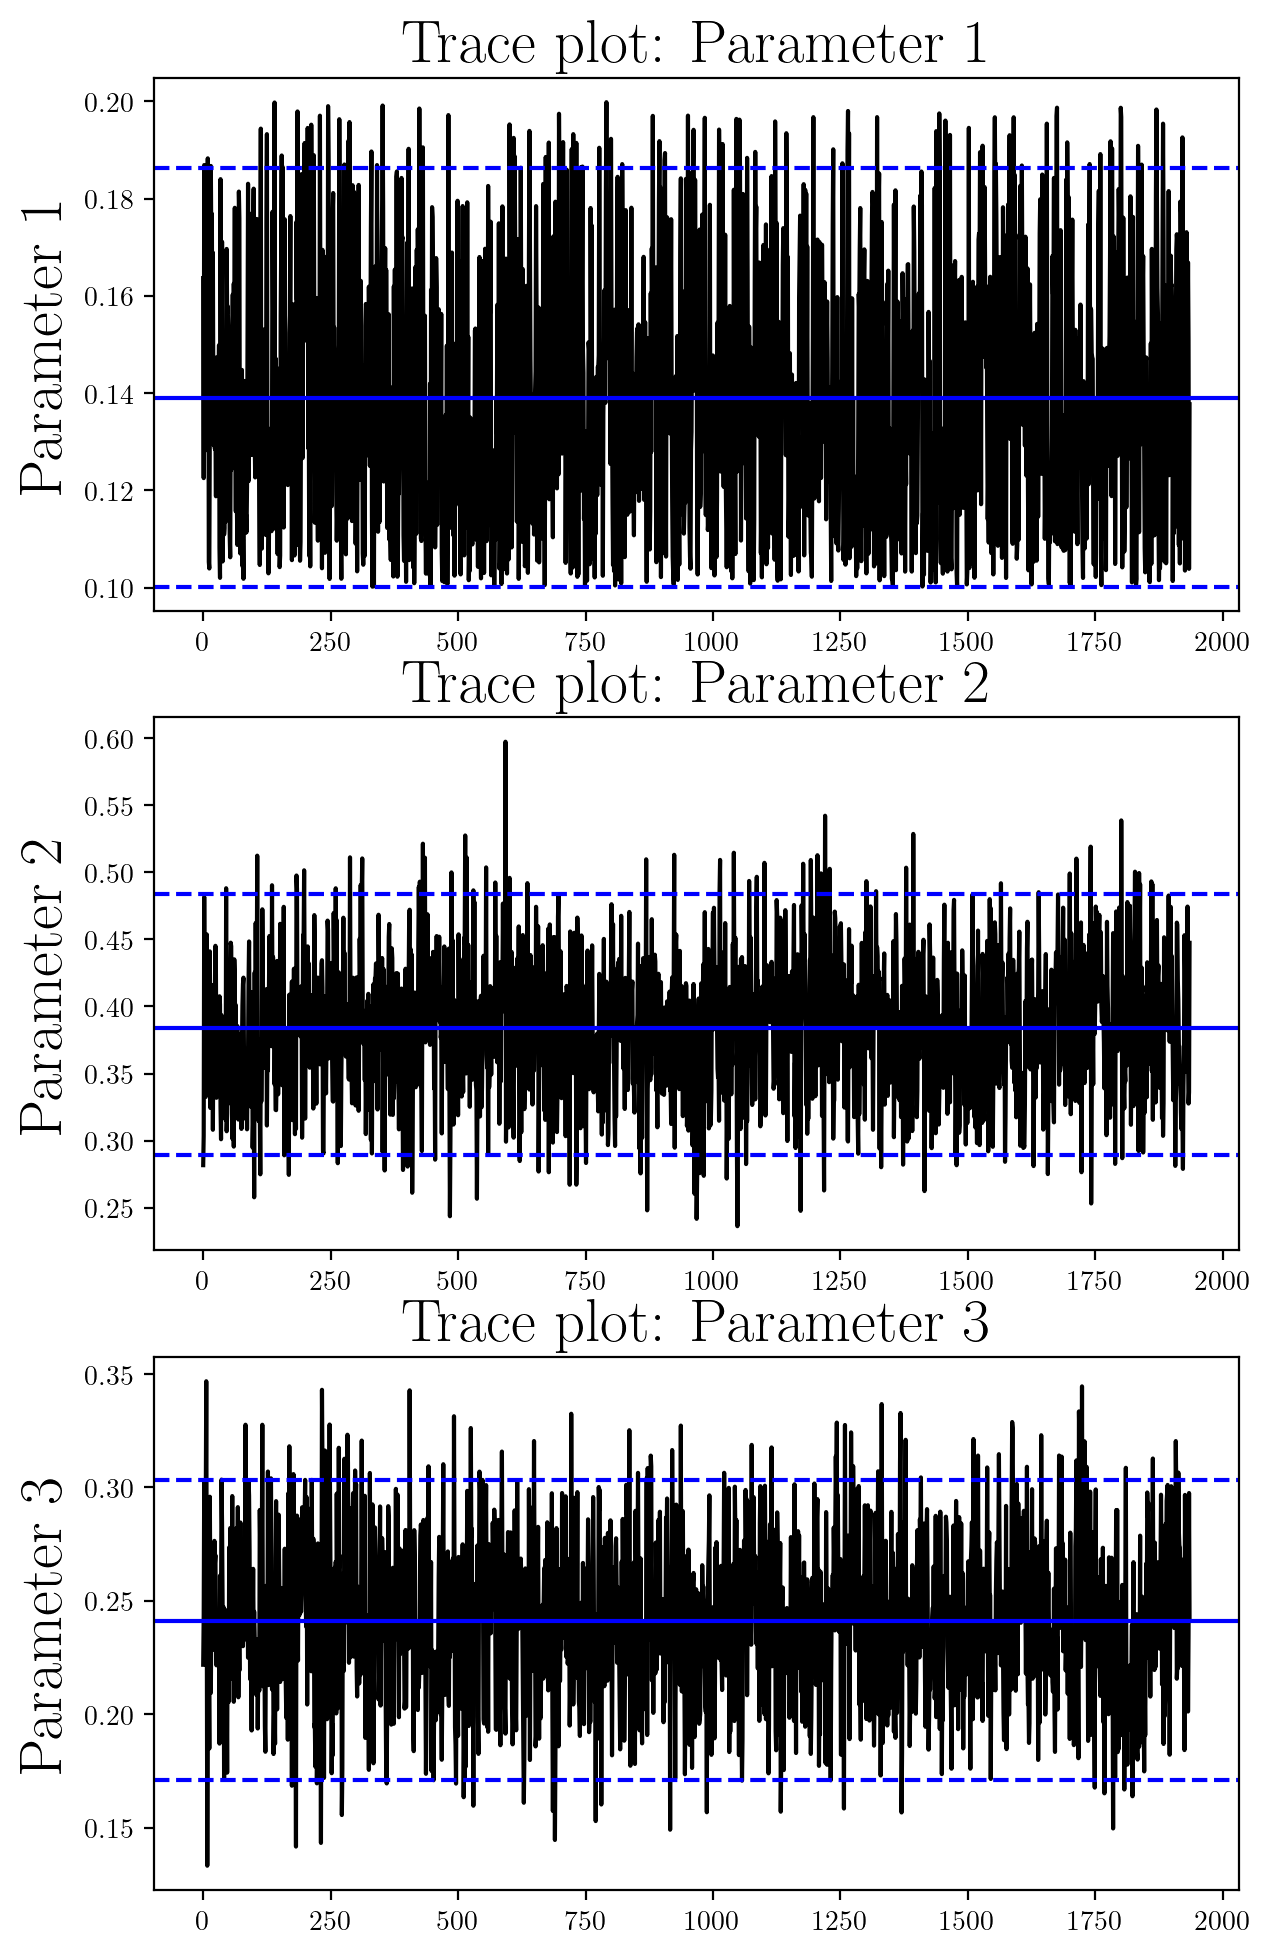

Would you like to save this figure? (yes/no)no
235
The median values are: 1 = 0.13566348110179485; 2 = 0.38265459367739973; 3 = 0.2415191010222217
The mean values are: 1 = 0.13901896193813998; 2 = 0.3837597955087808; 3 = 0.24126053945900258


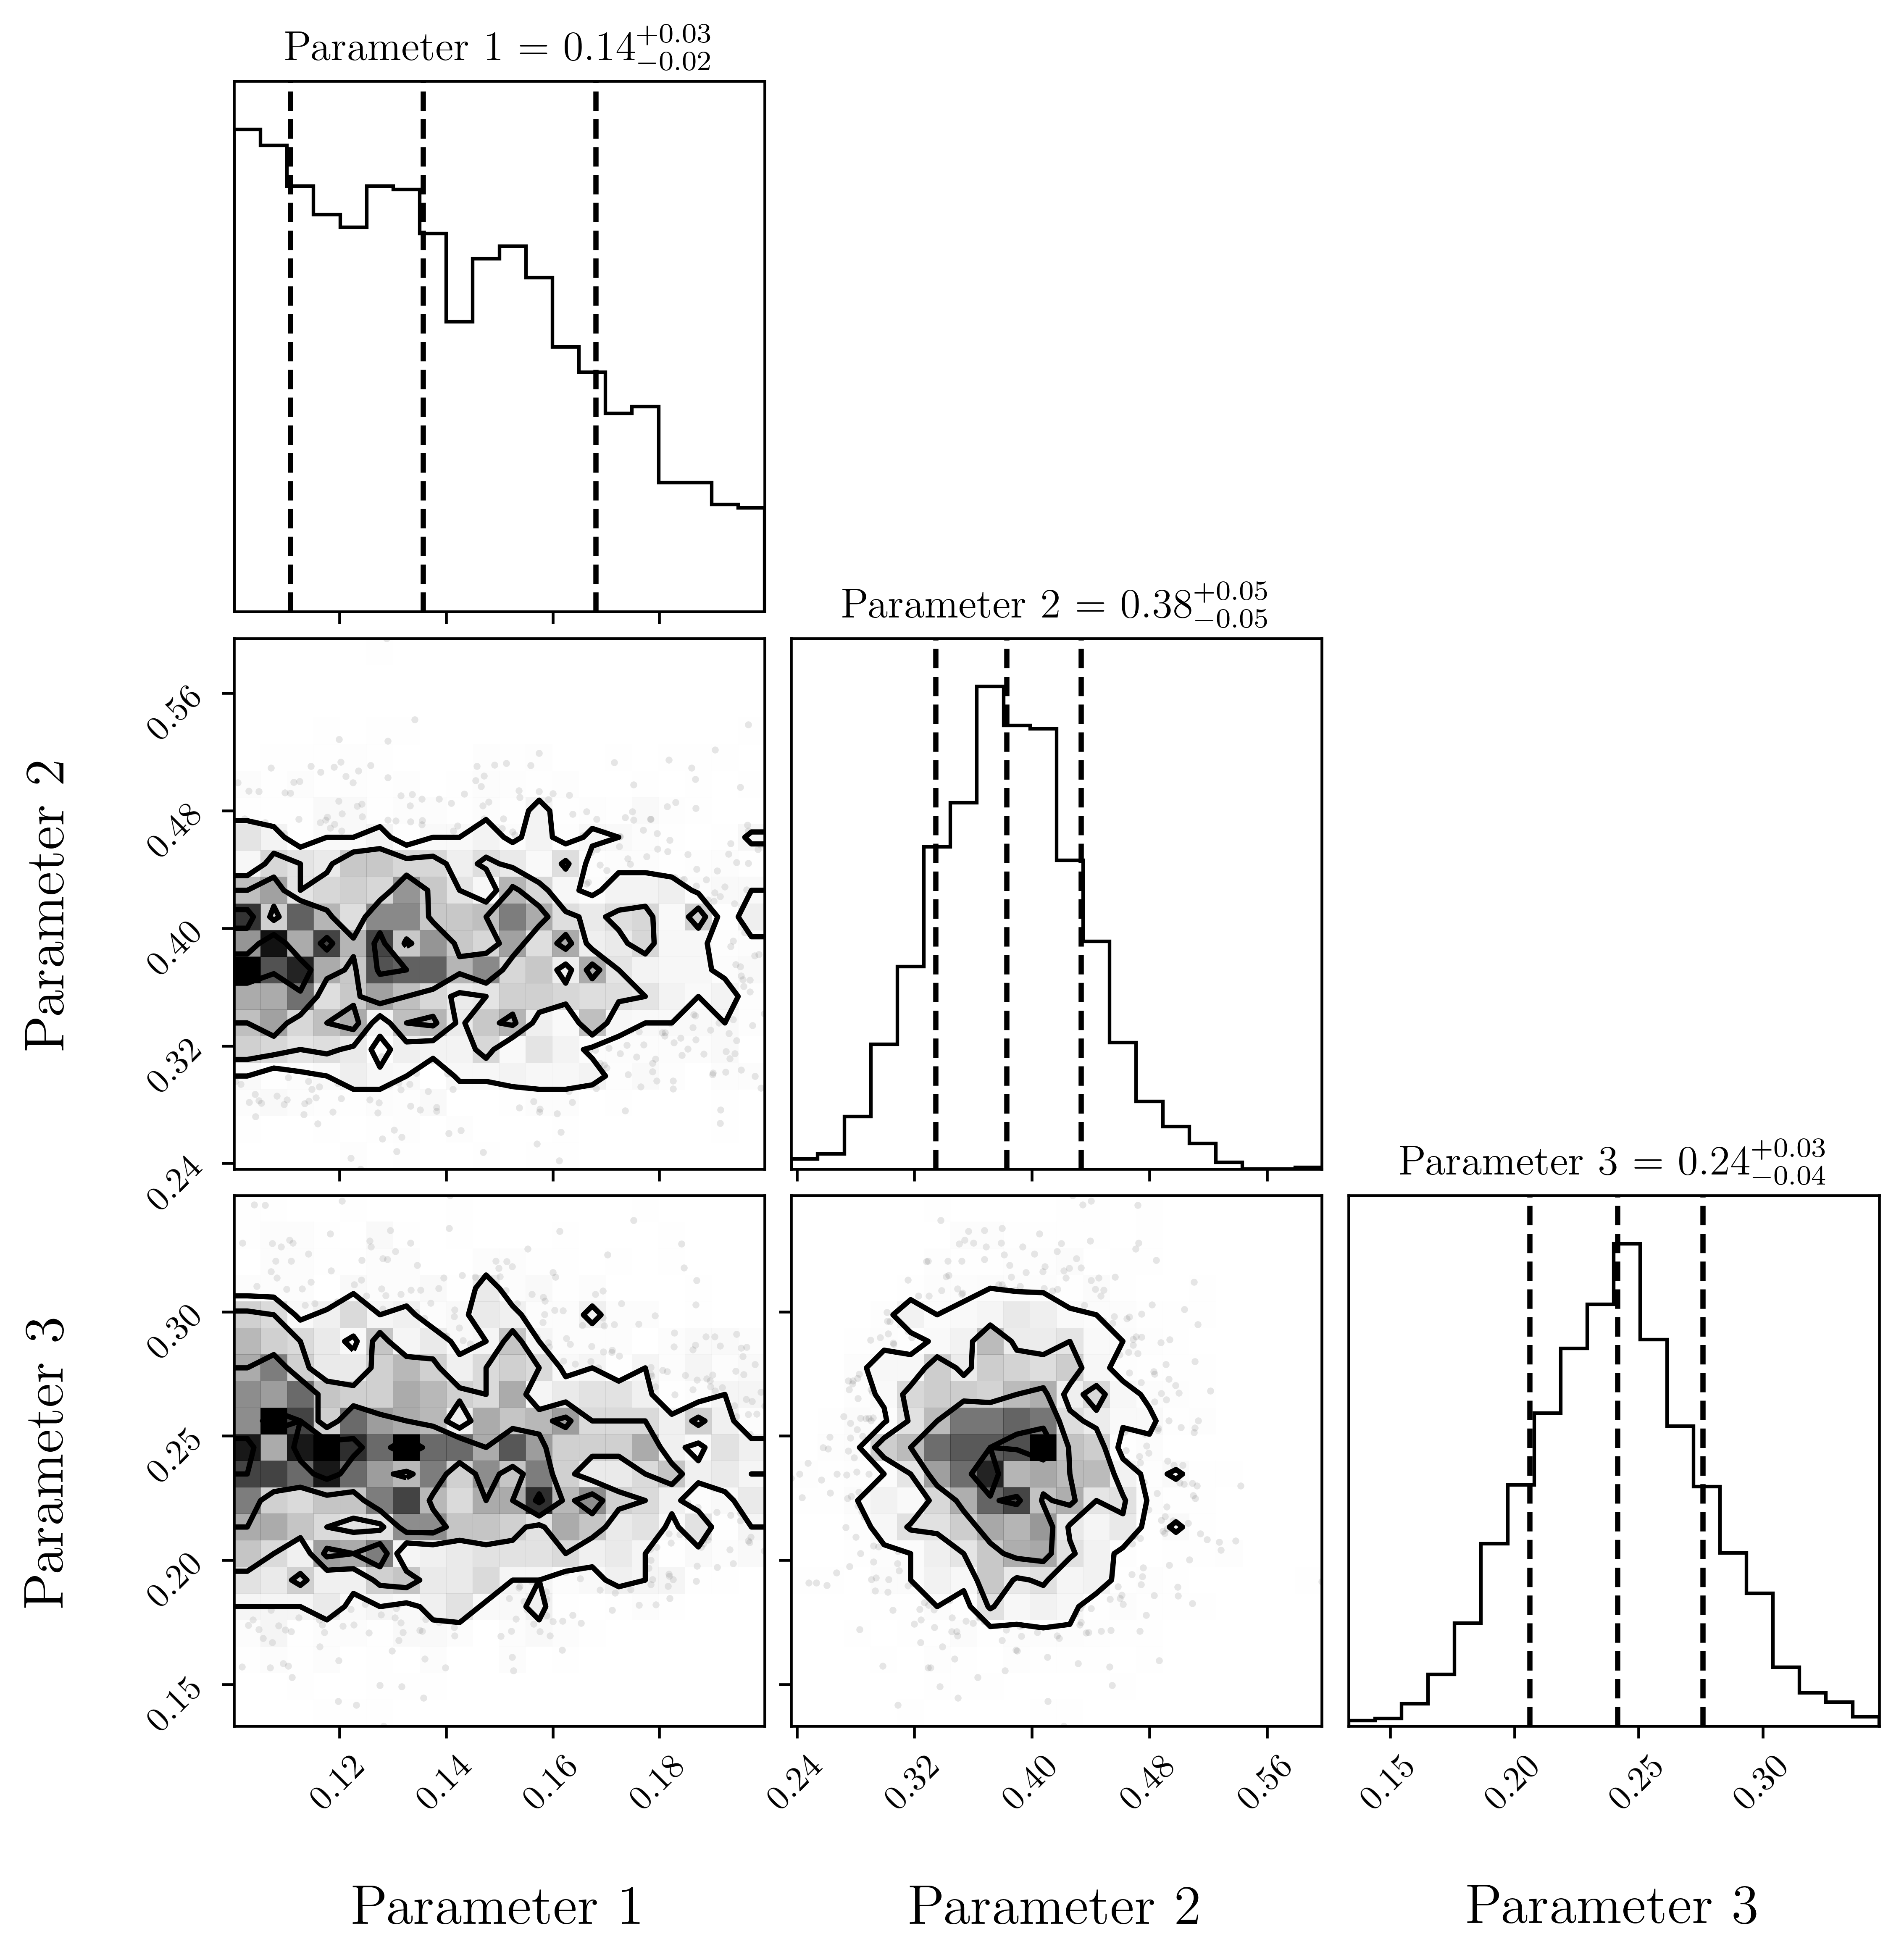

In [14]:
#flatten into a 1d arrays
flat1 = chain1.flatten()
flat2 = chain2.flatten()
flat3 = chain3.flatten()

print(np.shape(flat1))

#determine autocorrelation of each parameter chain
post_acors1 = autocorrelation(flat1, max_lag=200)
post_acors2 = autocorrelation(flat2, max_lag=200)
post_acors3 = autocorrelation(flat3, max_lag=200)

# #fig, ax = plt.subplots(2,1, figsize=(8,6), dpi=200)
# fig, ax = plt.subplots(3,1, figsize=(8,6), dpi=200)
# ax[0].plot(post_acors1)
# ax[1].plot(post_acors2)
# ax[2].plot(post_acors3)

# for i in range(3):
# #for i in range(2):
#     ax[i].set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));
# ax[0].set_title(f'Autocorrelation function: before thinning: g1, g2, g3')

#determine the autocorrelation time
post_rho1 = post_acors1[25:35]
post_rho2 = post_acors2[25:35]
post_rho3 = post_acors3[25:35]

# fig,ax = plt.subplots(3,1, figsize=(8,6), dpi=200)
#fig,ax = plt.subplots(2,1, figsize=(8,6), dpi=200)
post_y = np.arange(10)
post_x1 = -np.log(post_rho1)
post_x2 = -np.log(post_rho2)
post_x3 = -np.log(post_rho3)
        
# ax[2].set_xlabel(r'ln($\rho(h)$)')
#for i in range(2):
# for i in range(3):
#     ax[i].set_ylabel('h')
# ax[0].set_title('Autocorrelation time')
# ax[0].plot(post_x1, post_y)
# ax[1].plot(post_x2, post_y)
# ax[2].plot(post_x3, post_y)

#linear fits
p1, cov1 = np.polyfit(post_x1, post_y, 1, cov = True)
p2, cov2 = np.polyfit(post_x2, post_y, 1, cov=True)
p3, cov3 = np.polyfit(post_x3, post_y, 1, cov=True)

print('The autocorrelation information is: p = {}; cov = {}'.format(p1, cov1))
print('The autocorrelation information is: p = {}; cov = {}'.format(p2, cov2))
print('The autocorrelation information is: p = {}; cov = {}'.format(p3, cov3))

print('The autocorrelation time is: {}'.format(p1[0]))
print('The autocorrelation time is: {}'.format(p2[0]))
print('The autocorrelation time is: {}'.format(p3[0]))

# ax[0].plot(post_x1, p1[0]*post_x1 + p1[1])
# ax[1].plot(post_x2, p2[0]*post_x2 + p2[1])
# ax[2].plot(post_x3, p3[0]*post_x3 + p3[1])

#adjust the samples by thinning according to the autocorrelation time
thin1 = []
thin2 = []
thin3 = []

#get the autocorrelation time we use for all 3 parameters
if p1[0] > p2[0]:
    time = p1[0]
else:
    time = p2[0]
    if p3[0] > time:
        time = p3[0]
time = int(time)
        
for i in range(len(flat2)):
    if i % time == 0:
        thin1.append(flat1[i])
        thin2.append(flat2[i])
        thin3.append(flat3[i])
                    
#array thinned samples
thin1 = np.array(thin1)
thin2 = np.array(thin2)
thin3 = np.array(thin3)

#stack traces back together
#thin = np.vstack((thin1, thin2))
thin = np.vstack((thin1, thin2, thin3))
print(thin)
print(type(thin))

#reposition (transpose)
print(np.shape(thin))

#new.stats_trace(thin, 2)
new.stats_trace(thin, 3)

#median calculation
median_1 = statistics.median(thin[0,:])
median_2 = statistics.median(thin[1,:])
median_3 = statistics.median(thin[2,:])

#mean calculation
mean_1 = np.mean(thin[0,:])
mean_2 = np.mean(thin[1,:])
mean_3 = np.mean(thin[2,:])

#MAP calculation 
H, edges = np.histogramdd(thin.T)
theta_indices = np.argmax(H)
print(theta_indices)

#arrays
mean_results = np.array([mean_1, mean_2, mean_3])
median_results = np.array([median_1, median_2, median_3])
#mean_results = np.array([mean_1, mean_2])
#median_results = np.array([median_1, median_2])

print('The median values are: 1 = {}; 2 = {}; 3 = {}'.format(median_1, median_2, median_3))
print('The mean values are: 1 = {}; 2 = {}; 3 = {}'.format(mean_1, mean_2, mean_3))

#print('The median values are: 1 = {}; 2 = {}'.format(median_1, median_2))
#print('The mean values are: 1 = {}; 2 = {}'.format(mean_1, mean_2))

## MAP value calculation

In [15]:
#call Uncertainties class for the theory errors (variances)
err = Uncertainties()
siglow = np.sqrt(err.variance_low(g_data, lowk[0]))
sighigh = np.sqrt(err.variance_high(g_data, highk[0]))
print(siglow, sighigh)

Which error model do you want to use, uninformative or informative? (u/i)i
[3.29431612e-03 1.85096280e-02 7.06086275e-02 2.10836232e-01
 5.31650203e-01 1.18461619e+00 2.40155645e+00 4.51895216e+00
 8.00559941e+00 1.34935188e+01] [1.39271521e+02 2.14664649e+01 5.03321459e+00 1.53874745e+00
 5.64954165e-01 2.37173171e-01 1.10299657e-01 5.56096901e-02
 2.99294007e-02 1.70009181e-02]


In [16]:
thetas = np.vstack((thin1, thin2, thin3))
print(np.shape(thetas))

#params 
posterior = np.zeros([len(thin1)])
for i in range(len(thin1)):
    posterior[i] = new.sampler_mix(thetas[:,i], g_data, data, sigma, siglow, sighigh, loworder=lowk)
    
#MAP value calculation
theta_index = np.argmax(posterior)
print(theta_index)

print(posterior[theta_index])
map_values = thetas[:, theta_index]
print('MAP values: ', map_values)

(3, 1936)
189
19.825014135949488
MAP values:  [0.11420805 0.38053267 0.24378647]


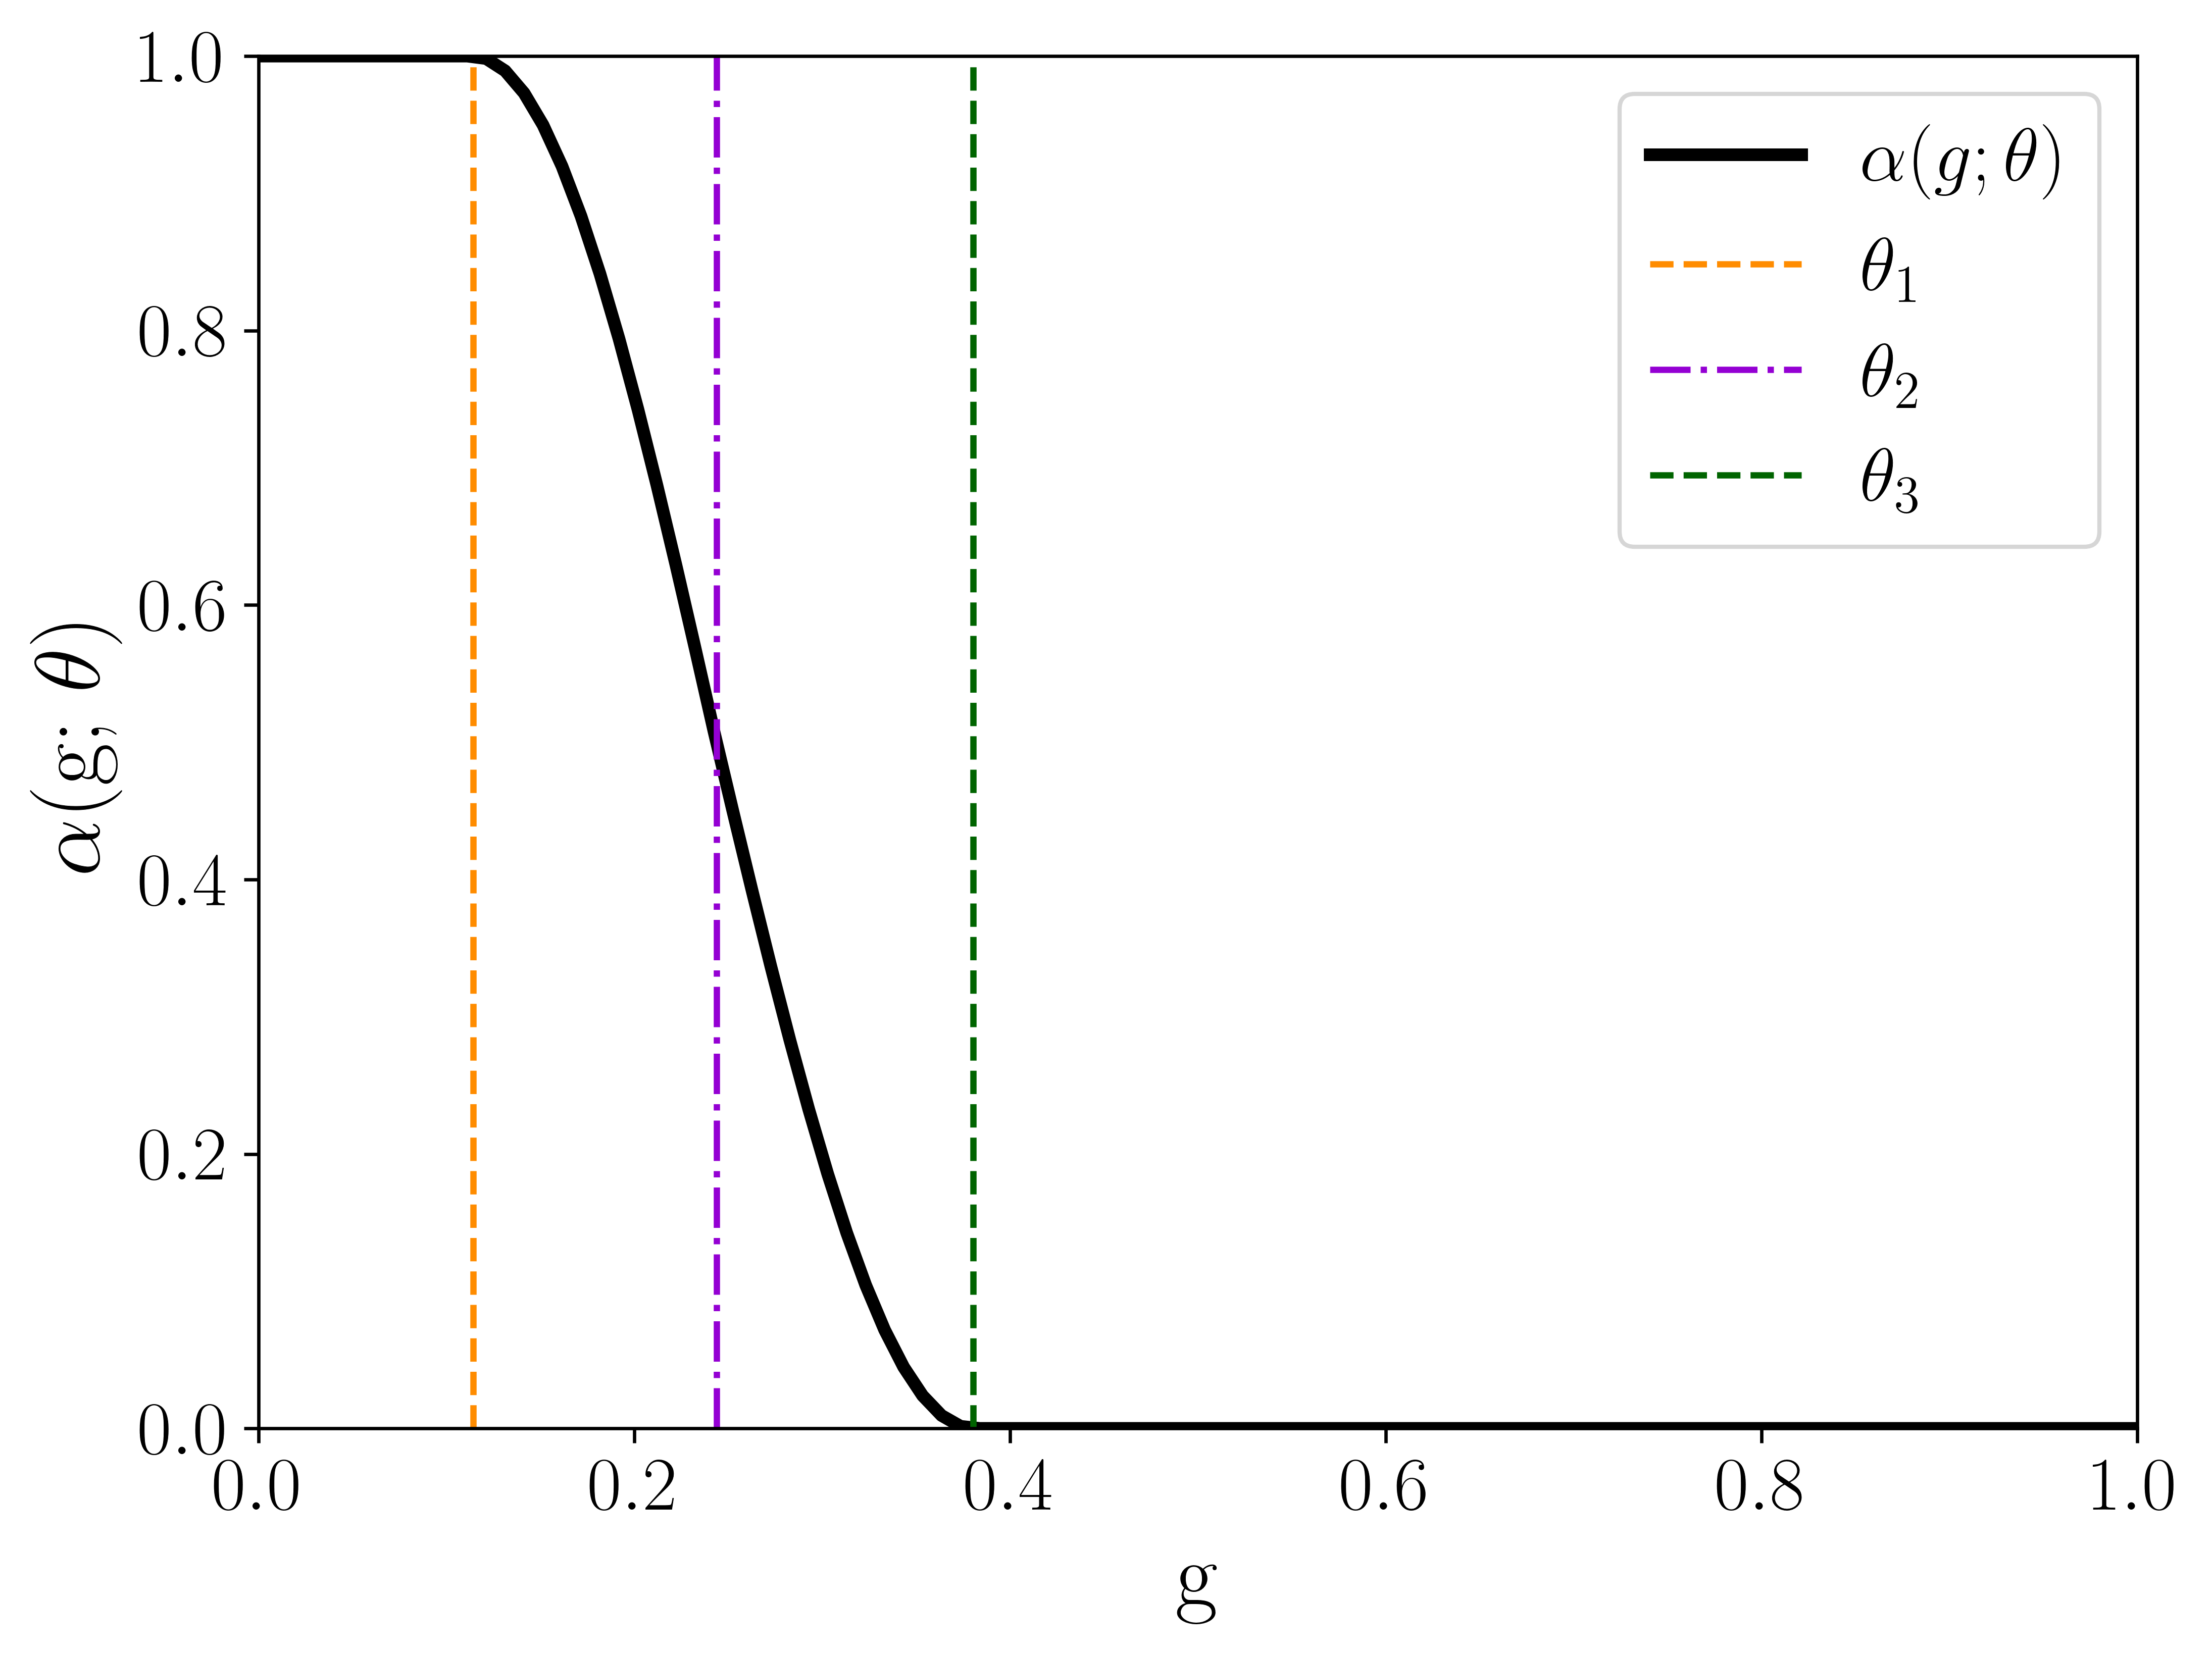

In [17]:
#make plots for the MAP values (rough drafts)
fig = plt.figure(figsize=(8,6), dpi=600)
ax = plt.axes()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0,1.0)
ax.set_xlabel('g', fontsize=22)
ax.set_ylabel(r'$\alpha$(g; $\theta$)', fontsize=22)

#solve the cosine function first
switch = np.zeros([len(g)])
for i in range(len(g)):
    switch[i] = new.switchcos(np.array([map_values[0], map_values[1], map_values[2]]), g[i])

ax.plot(g, switch, 'k', linewidth=3, label=r'$\alpha(g; \theta)$') 
ax.axvline(x=map_values[0], color='darkorange', linestyle='dashed', label=r'$\theta_{1}$')
ax.axvline(x=map_values[2], color='darkviolet', linestyle='dashdot', label=r'$\theta_{2}$')
ax.axvline(x=map_values[1], color='darkgreen', linestyle='dashed', label=r'$\theta_{3}$')

ax.legend(loc='upper right', fontsize=18)

fig.savefig('mixing_plot_MAP_5v5.pdf', bbox_inches='tight')

plt.show()

Which error model would you like to use: uninformative (u) or informative (i)?i
Which interval do you want to use: 68 or 95?68


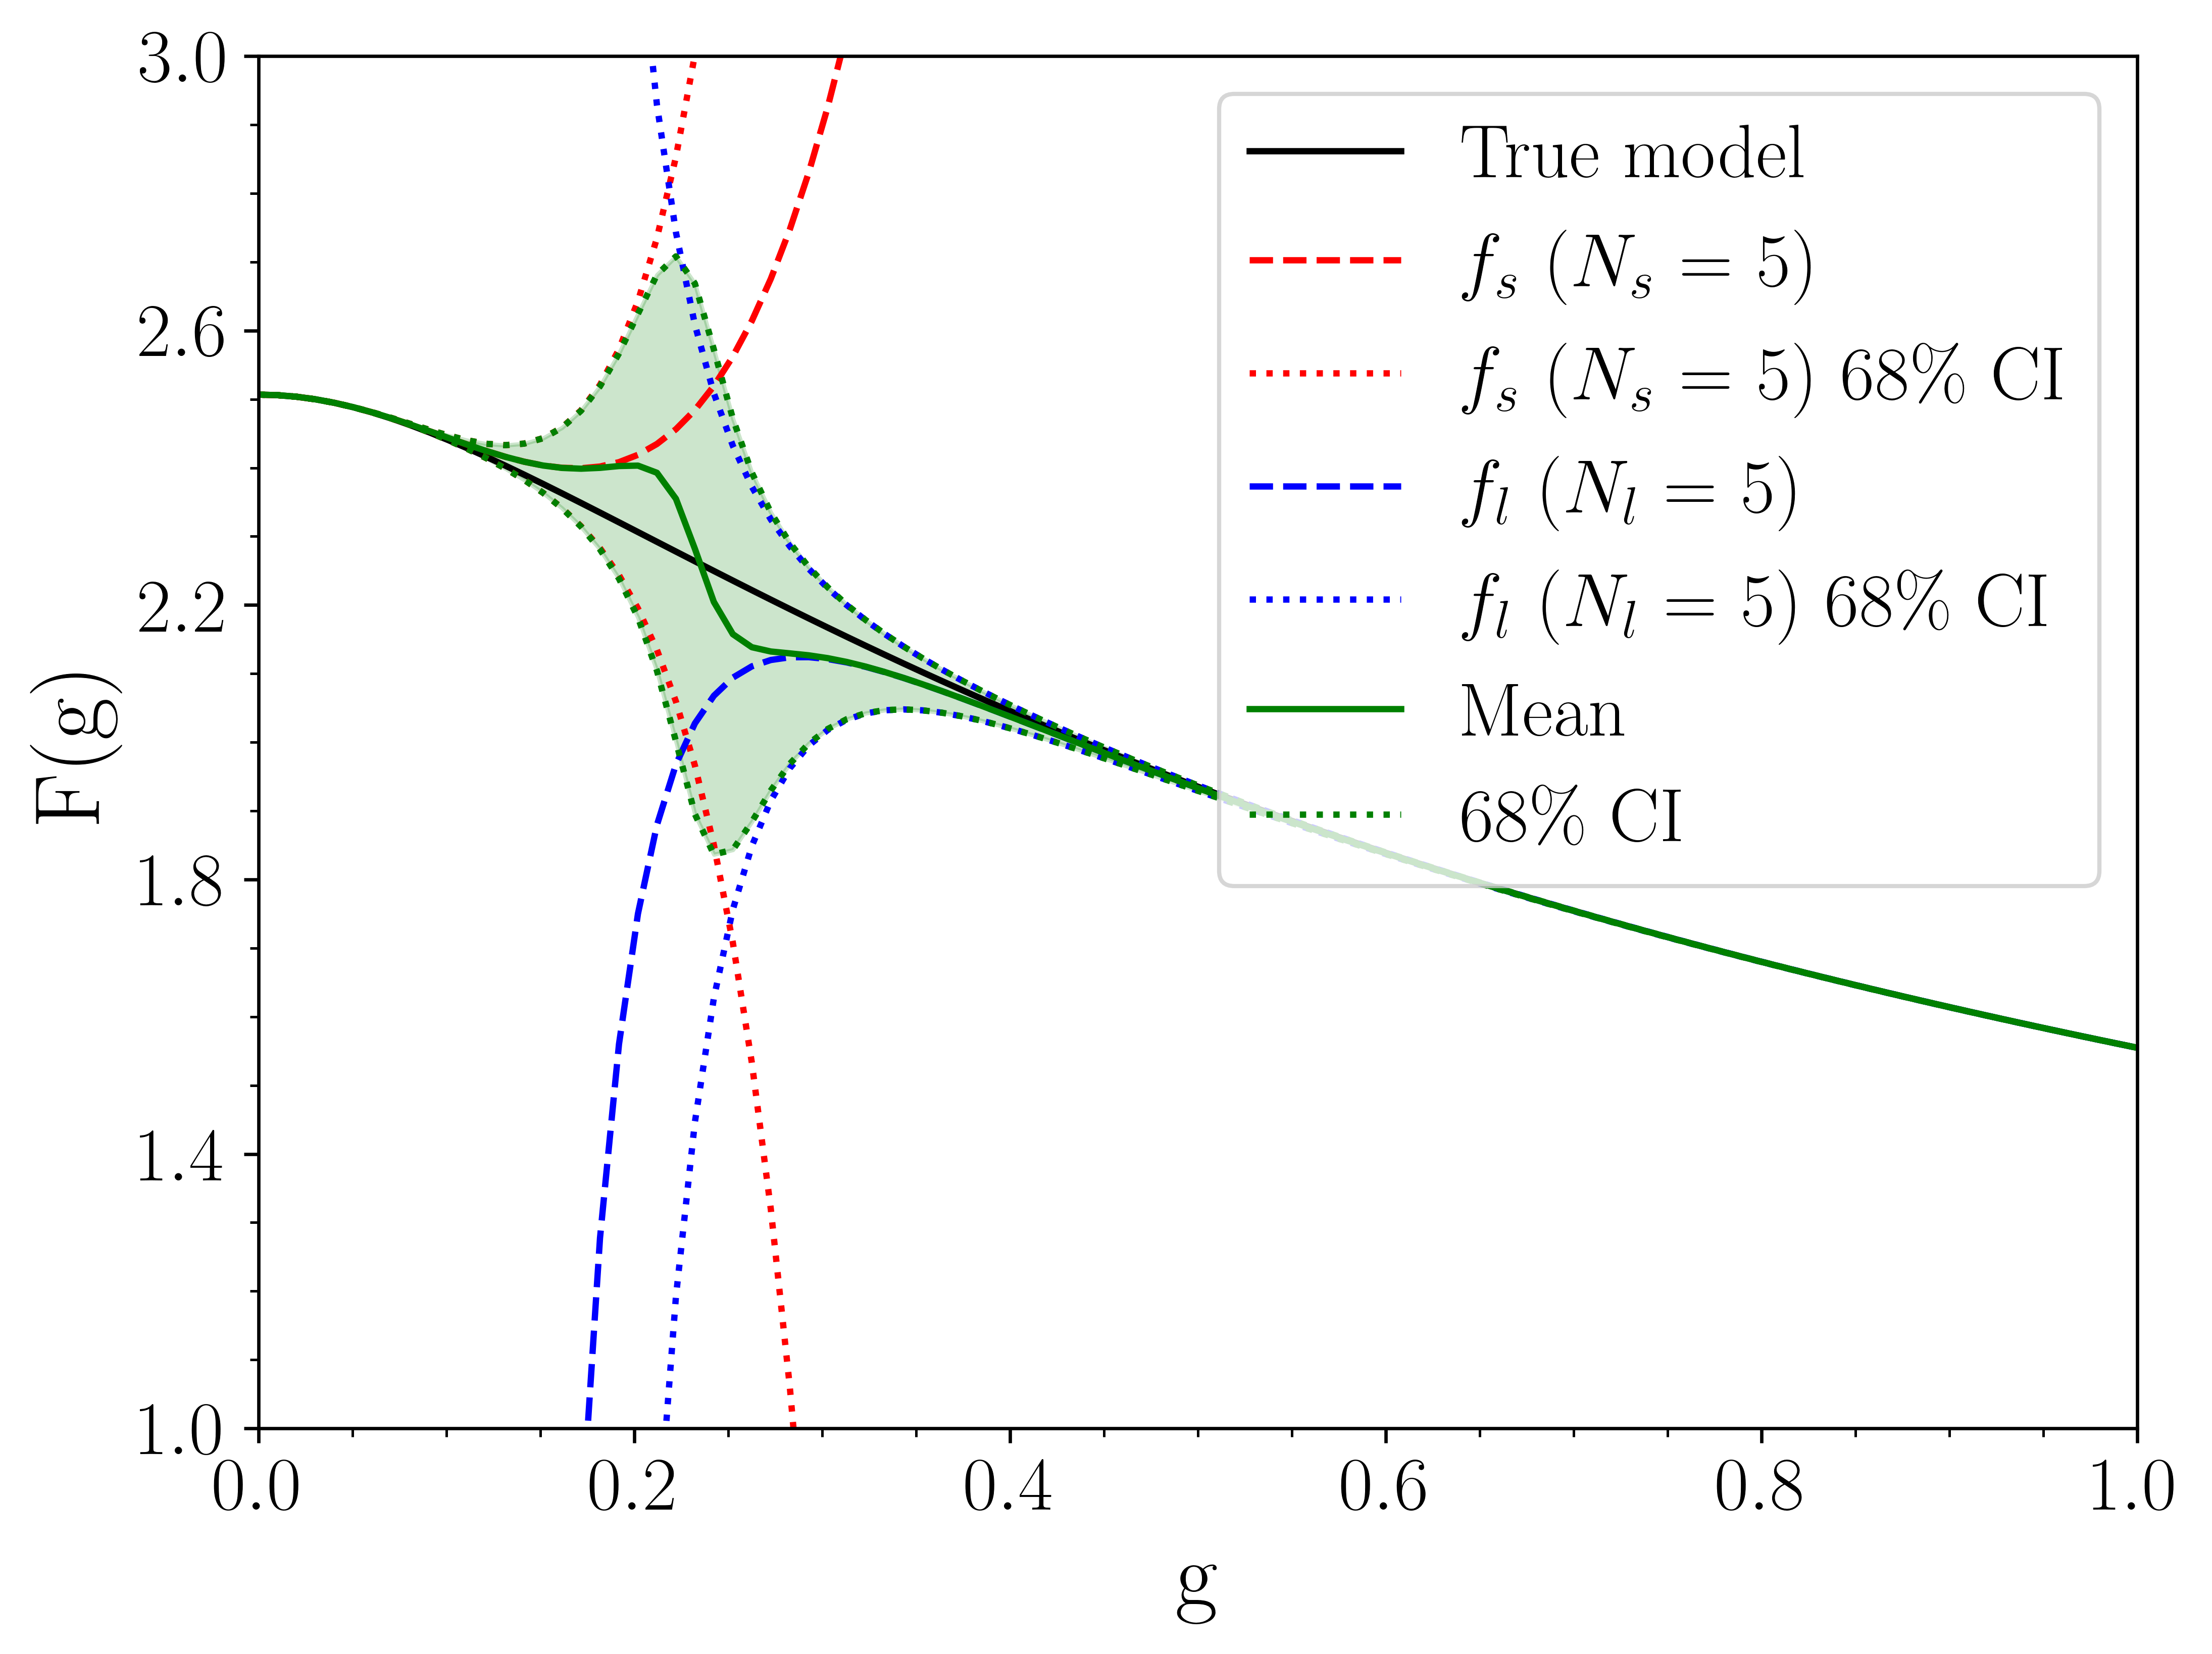

Would you like to save this figure? (yes/no)no


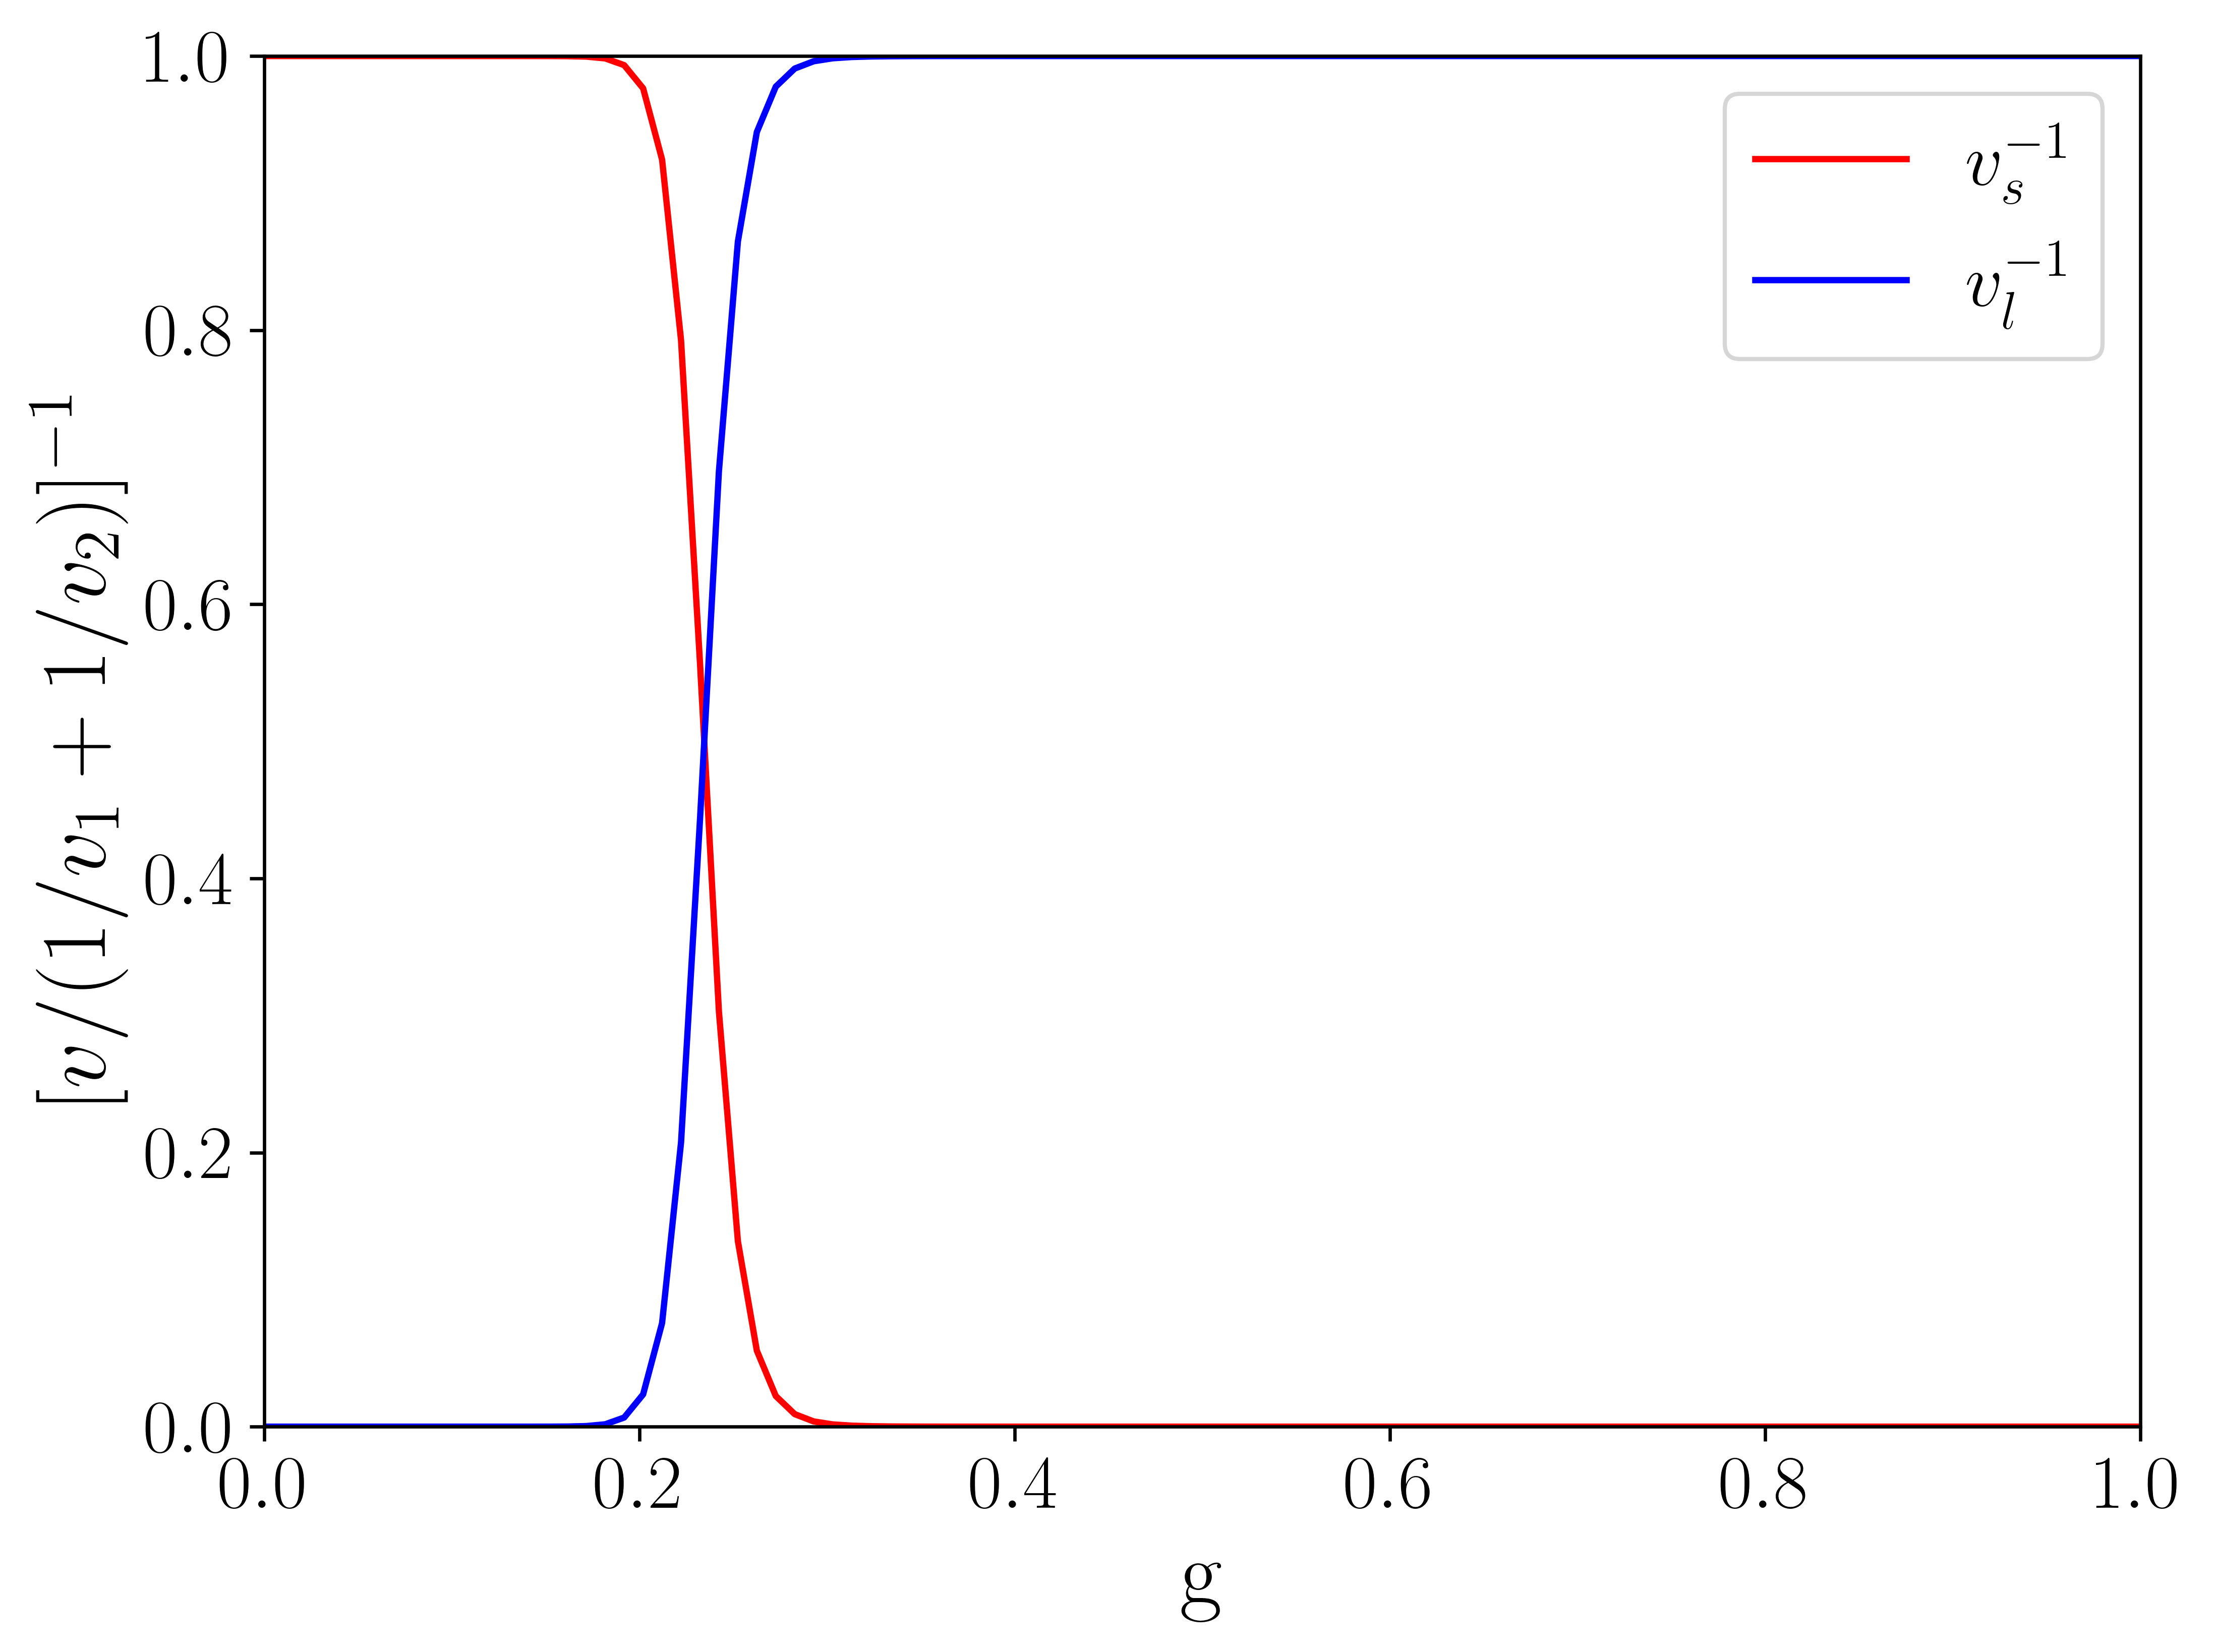

In [20]:
objw = Discrepancy(highk)
mean, intervals = objw.plot_mix(g, lowk, plot_fdagger=True, plot_true=True)

#pull the weights and plot
var1 = objw.var_weights[0]
var2 = objw.var_weights[1]

#figure 
fig = plt.figure(figsize=(8,6), dpi=600)
ax = plt.axes()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0,1.0)
ax.set_xlabel('g', fontsize=22)
ax.set_ylabel(r'$[v/(1/v_1 + 1/v_2)]^{-1}$', fontsize=22)
ax.plot(g, var1, 'r', label=r'$v_{s}^{-1}$')
ax.plot(g, var2, 'b', label=r'$v_{l}^{-1}$')

ax.legend(loc='upper right', fontsize=18)

plt.show()

## PPD calculation

In [ ]:
g_ppd = np.linspace(1e-6, 1.0, 100)

switch_results_ppd = new.ppd(thin, g_ppd, lowk, highk)

switch_med_results = np.empty([len(g_ppd)])
switch_mode_results = np.empty([len(g_ppd)])
switch_g_intervals = np.empty([len(g_ppd), 2])

for i in range(len(g_ppd)):
    switch_med_results[i] = statistics.median(switch_results_ppd[i,:])
    switch_mode_results[i] = np.max(switch_results_ppd[i,:])
    switch_g_intervals[i, :] = new.credible_intervals(switch_results_ppd[i,:], 0.68)

In [ ]:
new.plot_ppd(median_results, g_data, g, g_ppd, data, switch_med_results, switch_g_intervals, 68, lowk, highk)

In [ ]:
#plot the histogram for one value of g (somewhere in it)
print(g[46])

#make the histogram
fig = plt.figure(figsize=(8,6), dpi=100)
hi = plt.axes()
hi.set_title('g = 0.2323 (approx. g3 parameter median value)')
hi.set_xlabel('Value of F(g)')
hi.set_ylabel('Number of samples')
N, bins, patches = hi.hist(switch_results_ppd[46,:], bins=20, color='black', edgecolor='white', linewidth=1.2)
plt.show()

In [ ]:
#plot the histogram for one value of g (somewhere in it)
print(g[30])

# #make the histogram
fig = plt.figure(figsize=(8,6), dpi=100)
hi = plt.axes()
hi.set_xlim(2.0, 2.4)
hi.set_title('Approx 0.1515')
hi.set_xlabel('Value of F(g)')
hi.set_ylabel('Number of samples')
N, bins, patches = hi.hist(switch_results_ppd[30,:], bins=50, color='black', edgecolor='white', linewidth=1.2)
plt.show()

print(np.mean(switch_results_ppd[30,:]))
print(np.std(switch_results_ppd[30,:]))

Now we'll show the mean and the central credibility interval on a separate plot. We need to pick one of the two methods to use for the DNP talk/the project.

In [ ]:
g_ppd = np.linspace(1e-6, 0.5, 100)

switch_results_ppd = new.ppd(thin, g_ppd, lowk, highk)

switch_mean_results = np.empty([len(g_ppd)])
switch_g_intervals = np.empty([len(g_ppd), 2])
variance = np.zeros([len(g)])

for i in range(len(g_ppd)):
    switch_mean_results[i] = np.mean(switch_results_ppd[i,:])
    variance[i] = np.sum((switch_results_ppd[i,:] - switch_mean_results[i])**2.0)/len(switch_results_ppd[i,:])
    
#interval calculation (68%)
interval = np.zeros([len(g), 2])

for i in range(len(g)):
    interval[i, 0] = switch_mean_results[i] - 1.0*np.sqrt(variance[i])
    interval[i, 1] = switch_mean_results[i] + 1.0*np.sqrt(variance[i])

In [ ]:
new.plot_ppd(median_results, g_data, g, g, data, switch_mean_results, interval, 68, lowk, highk)

In [ ]:
mean, intervals = new.stats_trace(trace, len(trace))

print('Mean results: ', mean)

The above seems to be returning the prior...at least to a degree....

We can see from the traces above that the parameters look pretty well sampled, though some improvements are in the works. We can now use our results in calculating the posterior predictive distribution (PPD) for the mixed model. We will plot the mean and the credible intervals of the PPD along with our data and individual models to see how it looks.

In [ ]:
# switch_results_ppd = new.ppd(trace, g, lowk, highk)

# switch_mean_results = np.empty([len(g)])
# switch_g_intervals = np.empty([len(g), 2])
# variance = np.zeros([len(g)])

# for i in range(len(g)):
#     switch_mean_results[i] = np.mean(switch_results_ppd[i,:])
#     variance[i] = np.sum((switch_results_ppd[i,:] - switch_mean_results[i])**2.0)/len(switch_results_ppd[i,:])
#     switch_g_intervals[i, :] = new.credible_intervals(switch_results_ppd[i,:], 0.68)
    
# #credibility interval
# interval = np.zeros([len(g), 2])
# for i in range(len(g)):
#     interval[i, 0] = switch_mean_results[i] - 1.0*np.sqrt(variance[i])
#     interval[i, 1] = switch_mean_results[i] + 1.0*np.sqrt(variance[i])

In [ ]:
# new.plot_ppd(g_data, g, g, data, switch_mean_results, interval, 68, lowk, highk)

Now we have a plot of our results!

Some issues, however, with this model so far:
- The priors need to be __very__ narrow for the sampler to get a reasonable estimate of the parameters. Essentially, we have the problem of needing to already know the true model before we mix.
- The dip of the credible intervals on the left hand side of the plot still shows a tendency for the mixed model to follow the blue curve near that end. We may need more than two models to mix for this region to become smooth. 

## Mixing method 2: modelling discrepancies

We will now explore a different method of model mixing which bypasses the generation of data altogether, favouring the approach that the expansions were created from lab data themselves. In this case, we'll also see the inclusion of variances on the expansion models, which, in retrospect, makes much more sense than having them act as delta functions, as in the last method.

First, we need to think about how to set up an error model: we have two expansions in power series form, just as before. How do we imagine the error will look? A reasonable guess would be the next order in the series:

$$
f(x) = \sum_{n=0}^{N} c_{n} g^{n} \simeq c_{0} + c_{1} g + c_{2} g^{2} + c_{3} g^{3} + ... + c_{n} g^{n} + \mathcal{O}^{n + 1}
$$

We need to find the form of $\mathcal{O}^{n+1}$. We know, regarding this general power series, that it will be $c_{n+1} g^{n+1}$, but we do not know the form of the coefficient here. It is our first task to determine this.

We could go through the entire procedure step by step here, but for now let's shorten that and just say that we are going to pick the following two variance models for the two expansions:

$$
v_{1}^{(2n)} = \bar{c}^{2} (2n + 2)!^{2} g^{4n + 4},
$$

and

$$
v_{2}^{(m)} = \bar{d}^{2} (m + 1)!^{-2} g^{-2m - 2},
$$

where $m$ and $n$ are the different orders we are taking for the expansions, and $\bar{c}$, $\bar{d}$ represent the parts of the coefficients that come from the original known coefficients in the expansion. The important thing to remember here is that the expansion's form would not be totally known to someone building the expansion models out of the lab data, so we need to estimate the next coefficient from the previous ones. 

To find $\bar{c}$ and $\bar{d}$, we take the rms of the previous coefficients. 

Now we are going to combined our models in the following manner and calculate the mean and credible intervals, much in the same way as the linear mixture. The posterior distribution here is given by:

$$
f_{\dagger} = \mathcal{N}\left(\frac{v_{2} f_{1} + v_{1} f_{2}}{v_{1} + v_{2}}, \frac{v_{1} v_{2}}{v_{1} + v_{2}} \right)
$$

In [ ]:
#set new orders
low = np.array([5])
high = np.array([5])

disc = Discrepancy()

pdf = disc.fdagger(g, low, high)

From the plot above, we can see that the discrepancy model (in green) is doing well in the centre, between the two models. It is not jumping around or discontinuously connecting the two models across the space. The credible intervals get really large in the centre, which we also expect since the variances of the expansions will open to envelope more range around the gap between the two models. At the ends, however, it works very well, which we were hoping for. 

Now let's plot some of the expansions and see if the next order in the expansion model fits within the error bands on the previous order.

In [ ]:
#set new orders
low = np.array([5])
high = np.array([5])

#pdf = disc.fdagger(g, low, high, plot_fdagger=False, next_order=True)

__Note__: Isn't f_s(6) supposed to be inside the intervals on f_s(5)? Oh boy...let's revisit the same thing we edited yesterday three times in a row. For 68 it is not, but for 95 it's almost exactly equal to the lower bound of the interval. 

Now we would like to do some validation; this involves using the known true coefficients of the next order terms as the variance of the models, and then seeing what we get.

In [ ]:
#next step goes here
#pdf = disc.fdagger(g, low, high, plot_fdagger=True, next_order=True, validation=True)

There is still quite a bit to do with this discrepancy method, and we are currently working on it and improving the linear mixture model.

This all leads to the questions we addressed before: how to make the mixed model predict more accurately in the centre between the two expansions. We will continue this project to look at having GPs in the centre and using data, or doing some more work with the error model here so that it does a better job. There are many threads to follow here!

One of those threads is to add more than two models into the mixing procedure. This can be done by expanding our code to include anywhere from 1 to $N$ models, as done below.

$$
f_{\dagger} = \frac{\sum_{i=1}^{N} f_{i}/v_{i}}{\sum_{i=1}^{N} 1/v_{i}}; ~~~~~~~ V = \frac{1}{\sum_{i=1}^{N} 1/v_{i}}
$$

All intellectual rights in the above work and imported "hand-written" class files to R. J. Furnstahl, D. R. Phillips, and A. Semposki. 
Thanks to Moses Chan for generously helping (and succeeding!) to fix the sampling procedure/functions/starting points in the linear mixture model. 

## 